# IMPORTS E CONFIGURAÇÕES

## Imports

In [1]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import pickle as pkl

from matplotlib import gridspec
from scipy import stats as ss

## Configurações

In [ ]:
plt.rcParams['figure.figsize'] = (20, 16)
pd.set_option('display.max_columns', None)

## Fonções Auxiliares

In [ ]:
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape # conta todas as linhas e colunas
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

def describe_num(df_num):
    # tendência central - mean, meadina
    ct1 = pd.DataFrame(df_num.apply(np.mean)).T
    ct2 = pd.DataFrame(df_num.apply(np.median)).T
    # dispersão - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(df_num.apply(np.std)).T
    d2 = pd.DataFrame(df_num.apply(min)).T
    d3 = pd.DataFrame(df_num.apply(max)).T
    d4 = pd.DataFrame(df_num.apply(
        lambda x: 
            x.max() - x.min()
        )
    ).T # range
    d5 = pd.DataFrame(
        df_num.apply(
            lambda x: 
                x.skew()
        )
    ).T
    d6 = pd.DataFrame(
        df_num.apply(
            lambda x: 
                x.kurtosis()
        )
    ).T
    # concatenar
    m = pd.concat([
        d2, 
        d3, 
        d4, 
        ct1, 
        ct2, 
        d1, 
        d5, 
        d6
    ]).T.reset_index()

    m.columns = [
        'attributes', 
        'min', 
        'max', 
        'range', 
        'mean', 
        'median', 
        'std', 
        'skew', 
        'kurtosis'
    ]
    return m

def describe_cat(df):
    # Para cada coluna categórica, calcula a porcentagem da categoria mais frequente
    percentuais = df.apply(lambda x: x.value_counts(normalize=True).iloc[0] * 100)
    percentuais = percentuais.to_frame(name='top_freq_percent')

    # Exibe o describe transposto e adiciona a coluna de percentual
    describe_cat = df.describe().T
    describe_cat['top_freq_percent'] = percentuais
    return describe_cat

# CARREGAMENTO DOS DADOS

## Carregar

In [4]:
# LOAD DATA
df1 = pkl.load( open( "../data/cleansed/df_cleansed.pkl", "rb" ) )

# CRIAÇÃO DE HIPÓTESES

**Lojas:**
> 1. Unidades com maior quantidade de funcionários tendem a apresentar vendas superiores.
> 2. Estabelecimentos com maior espaço de armazenamento costumam registrar mais vendas.
> 3. Lojas de maior tamanho geralmente vendem mais.
> 4. Unidades com variedade maior de produtos tendem a ter vendas mais elevadas.
> 5. Lojas com competidores mais próximos vendem menos.
> 6. Lojas com competidores a mais tempo vendem mais.

**Produtos:**
> 7. Lojas que destinam mais recursos para ações de marketing tendem a aumentar suas vendas.
> 8. Unidades com maior visibilidade dos produtos costumam vender mais.
> 9. Produtos com preços mais baixos tendem a ter maior volume de vendas.
> 10. Promoções com descontos mais expressivos costumam impulsionar as vendas.
> 11. Lojas com promoções ativas por mais tempo vendem mais.
> 12. Lojas com mais dias de promoção vendem mais.
> 13. Unidades que realizam promoções em sequência tendem a registrar vendas superiores.

**Tempo:**
> 14. Lojas que funcionam durante o Natal costumam vender mais.
> 15. As vendas das lojas tendem a crescer ao longo dos anos.
> 16. O volume de vendas costuma ser maior no segundo semestre.
> 17. Após o dia 10 de cada mês, as vendas tendem a aumentar.
> 18. Lojas vendem menos aos finais de semana.
> 19. Durante os períodos de férias escolares, as vendas costumam ser menores.

# ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

## Estatística Descritiva

### Separação dos Dados por Tipo

In [5]:
df_cat = df1.select_dtypes(include=['category'])
df_bool = df1.select_dtypes(include=['bool'])

cols_nums = [
    'Store',
    'Sales',
    'CompetitionDistance',
    'CompetitionOpenSinceYear',
    'Promo2SinceYear',
    'Year',
    'CompetitionTimeMonth'
]
df_num = df1[cols_nums].copy()

cols_ciclic = [
    'DayOfWeek',
    'CompetitionOpenSinceMonth',
    'Promo2SinceWeek',
    'Month',
    'Day',
    'WeekOfYear',
    'DayOfYear'
]
df_ciclic = df1[cols_ciclic].copy()

### Valores Categóricos

In [6]:
df_cat.head()

,StateHoliday,StoreType,Assortment
0,none,c,basic
1,none,a,basic
2,none,a,basic
3,none,c,extended
4,none,a,basic


In [7]:
describe_cat(df_cat)

,count,unique,top,freq,top_freq_percent
StateHoliday,844338,4,none,843428,99.892223
StoreType,844338,4,a,457042,54.130218
Assortment,844338,3,basic,444875,52.689207


### Valores Boleanos

In [8]:
df_bool.head()

,Promo,SchoolHoliday,Promo2
0,True,True,False
1,True,True,True
2,True,True,True
3,True,True,False
4,True,True,False


In [9]:
describe_cat(df_bool)

,count,unique,top,freq,top_freq_percent
Promo,844338,2,False,467463,55.364439
SchoolHoliday,844338,2,False,680893,80.642231
Promo2,844338,2,False,423292,50.133004


### Valores Numéricos

In [10]:
df_num.head()

,Store,Sales,CompetitionDistance,CompetitionOpenSinceYear,Promo2SinceYear,Year,CompetitionTimeMonth
0,1,5263,1270,2008,2015,2015,84
1,2,6064,570,2007,2010,2015,94
2,3,8314,14130,2006,2011,2015,105
3,4,13995,620,2009,2015,2015,71
4,5,4822,29910,2015,2015,2015,4


In [11]:
describe_num(df_num)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,Store,1.0,1115.0,1114.0,558.421374,558.0,321.730671,0.000426,-1.198836
1,Sales,46.0,41551.0,41505.0,6955.959134,6369.0,3103.813677,1.594929,4.854027
2,CompetitionDistance,20.0,200000.0,199980.0,5961.827515,2330.0,12592.173650,10.134908,145.288658
3,CompetitionOpenSinceYear,1900.0,2015.0,115.0,2010.331102,2012.0,5.502625,-7.217323,123.903078
4,Promo2SinceYear,2009.0,2015.0,6.0,2012.797915,2013.0,1.660124,-0.788296,-0.197911
5,Year,2013.0,2015.0,2.0,2013.831945,2014.0,0.777271,0.300865,-1.289874
6,CompetitionTimeMonth,-32.0,1407.0,1439.0,41.679672,16.0,66.814373,7.338856,126.855888


### Valores Cíclicos

In [12]:
df_ciclic.head()

,DayOfWeek,CompetitionOpenSinceMonth,Promo2SinceWeek,Month,Day,WeekOfYear,DayOfYear
0,5,9,31,7,31,31,212
1,5,11,13,7,31,31,212
2,5,12,14,7,31,31,212
3,5,9,31,7,31,31,212
4,5,4,31,7,31,31,212


In [13]:
describe_num(df_ciclic)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,DayOfWeek,1.0,7.0,6.0,3.520350,3.0,1.723711,0.019310,-1.259347
1,CompetitionOpenSinceMonth,1.0,12.0,11.0,6.787355,7.0,3.309915,-0.048451,-1.231875
2,Promo2SinceWeek,1.0,52.0,51.0,23.629083,22.0,14.288306,0.170399,-1.194815
3,Month,1.0,12.0,11.0,5.845774,6.0,3.323958,0.257706,-1.033190
4,Day,1.0,31.0,30.0,15.835706,16.0,8.683387,0.011112,-1.179671
5,WeekOfYear,1.0,52.0,51.0,23.646946,23.0,14.389922,0.262287,-1.025760
6,DayOfYear,1.0,365.0,364.0,162.387649,154.0,101.368895,0.268856,-1.025929


## Análise Univariada

### Valores Categóricos

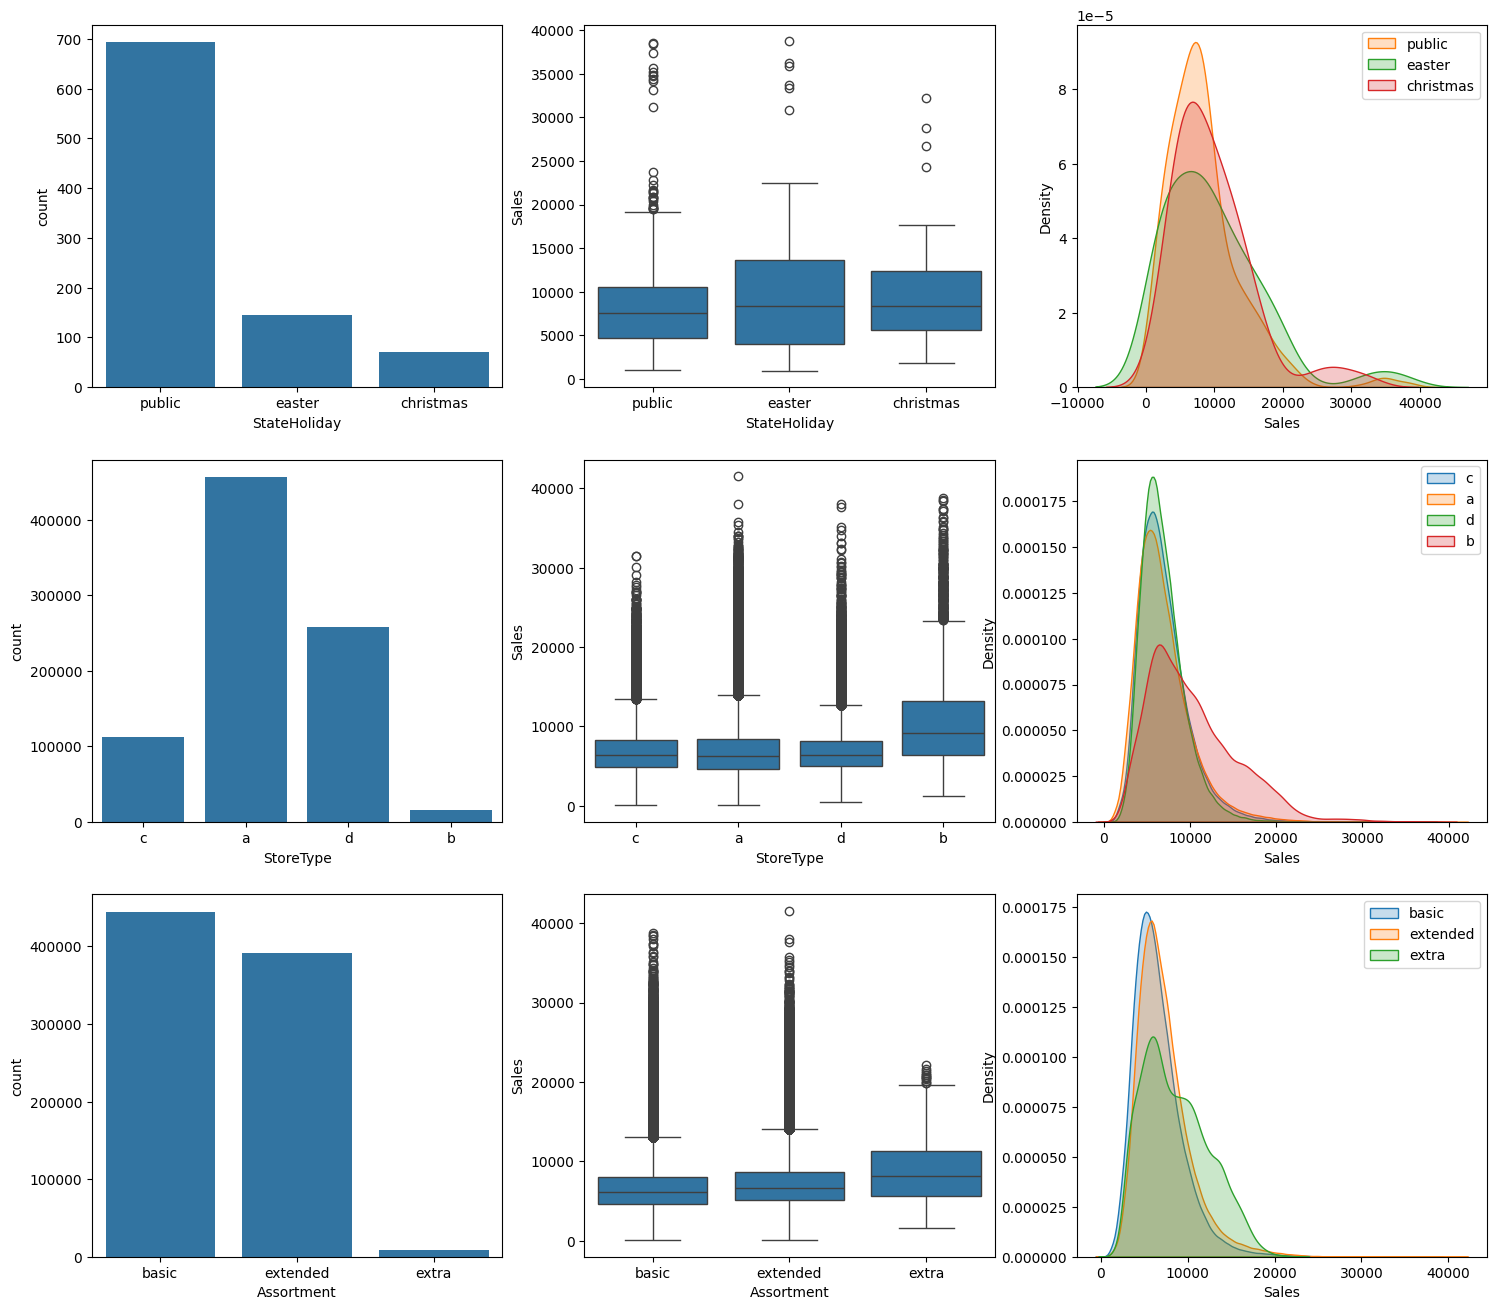

In [14]:
c = 3
r = len(df_cat.columns) 
cols = df_cat.columns.tolist()
cols.append('Sales')
aux1 = df1[cols].copy()

plt.figure(figsize=(18, 16))
for index, col in enumerate(df_cat.columns):
    p = index * c

    cols = []
    for val in aux1[col].unique():
        cols.append(val)

    if col == 'StateHoliday':
        cols.remove('none')
        aux2 = aux1[aux1['StateHoliday'] != 'none']
    else:
        aux2 = aux1

    plt.subplot(r, c, 1 + p)
    sns.countplot(data=aux2, x=col, order=cols)
    
    plt.subplot(r, c, 2 + p)
    sns.boxplot(data=aux2, x=col, y='Sales', order=cols)

    plt.subplot(r, c, 3 + p)
    for  val in df_cat[col].unique():
        sns.kdeplot(aux2[aux2[col] == val]['Sales'], label = val, fill = True )
    plt.legend()


### Valores Boleanos

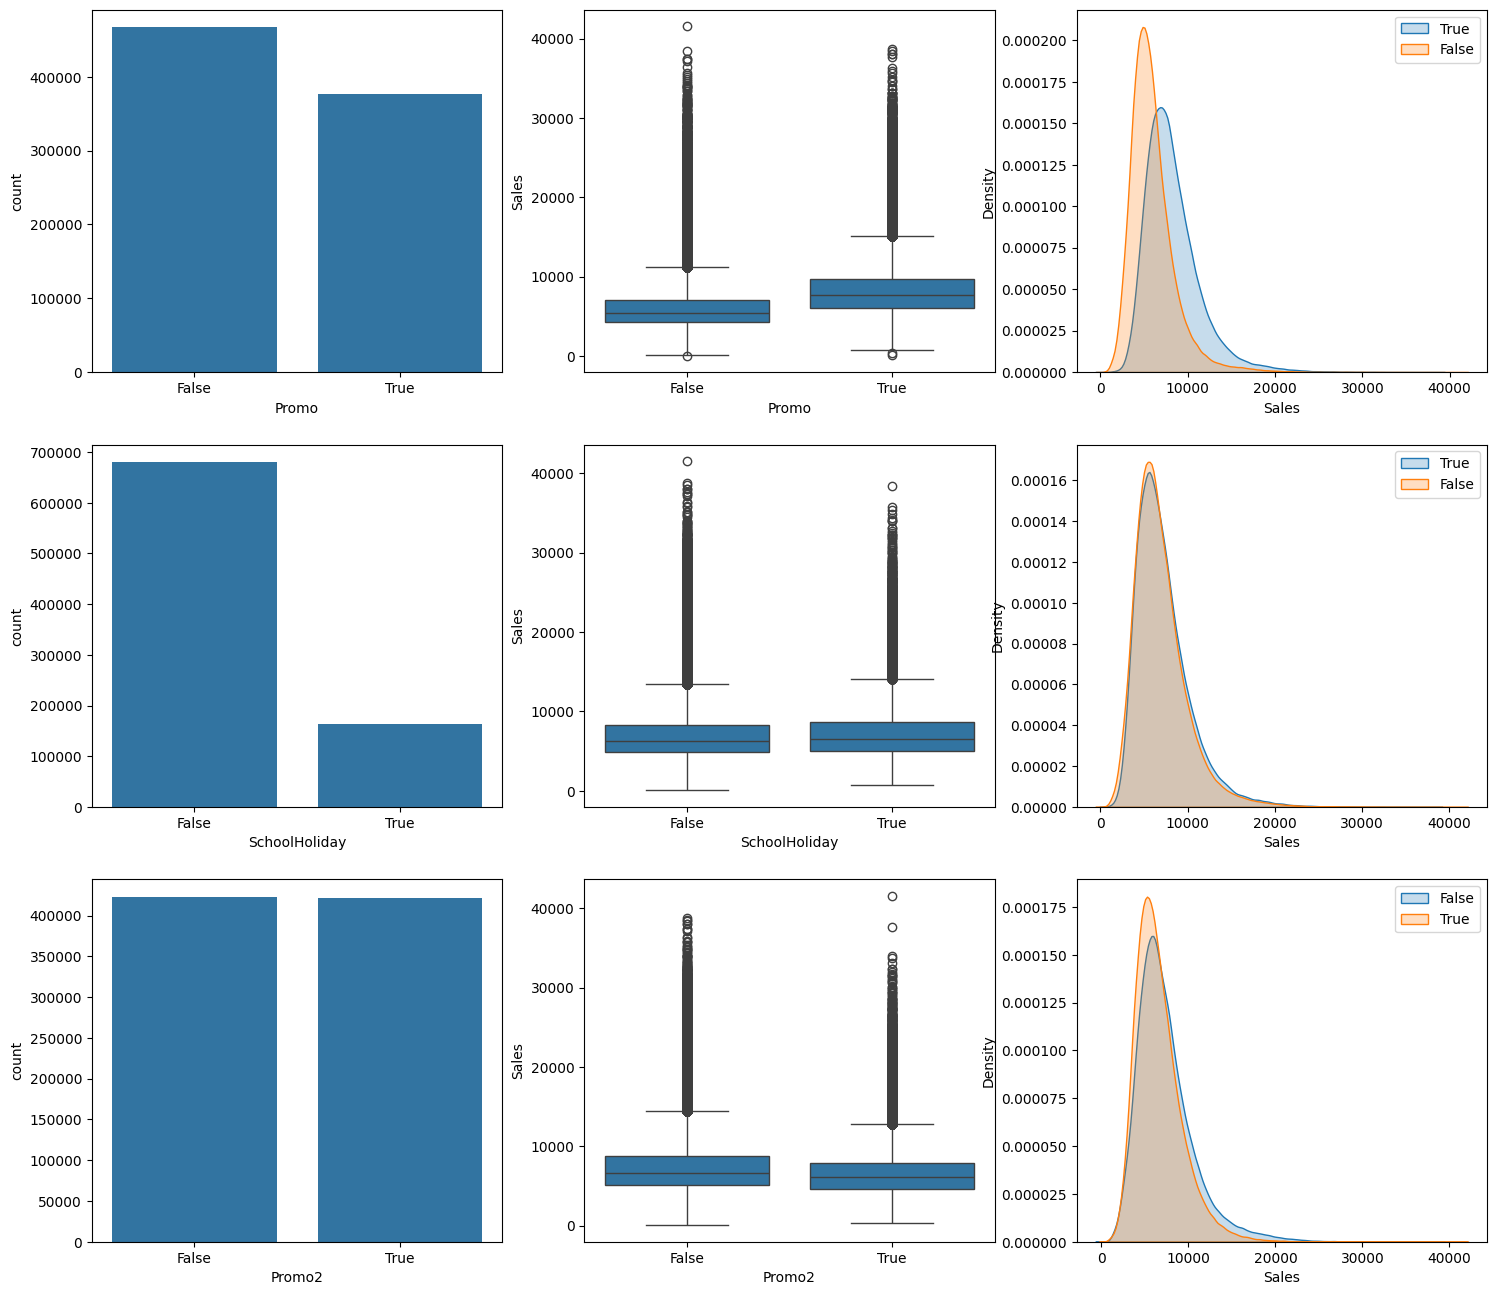

In [15]:
c = 3
r = len(df_bool.columns) 
cols = df_bool.columns.tolist()
cols.append('Sales')
aux1 = df1[cols].copy()

plt.figure(figsize=(18, 16))
for index, col in enumerate(df_bool.columns):
    p = index * c

    cols = []
    for val in aux1[col].unique():
        cols.append(val)

    plt.subplot(r, c, 1 + p)
    sns.countplot(data=aux1, x=col)
    
    plt.subplot(r, c, 2 + p)
    sns.boxplot(data=aux1, x=col, y='Sales')

    plt.subplot(r, c, 3 + p)
    for  val in df_bool[col].unique():
        sns.kdeplot(aux1[aux1[col] == val]['Sales'], label = val, fill = True )
    plt.legend()

### Valores Numéricos

array([[<Axes: title={'center': 'Store'}>,
        <Axes: title={'center': 'Sales'}>,
        <Axes: title={'center': 'CompetitionDistance'}>],
       [<Axes: title={'center': 'CompetitionOpenSinceYear'}>,
        <Axes: title={'center': 'Promo2SinceYear'}>,
        <Axes: title={'center': 'Year'}>],
       [<Axes: title={'center': 'CompetitionTimeMonth'}>, <Axes: >,
        <Axes: >]], dtype=object)

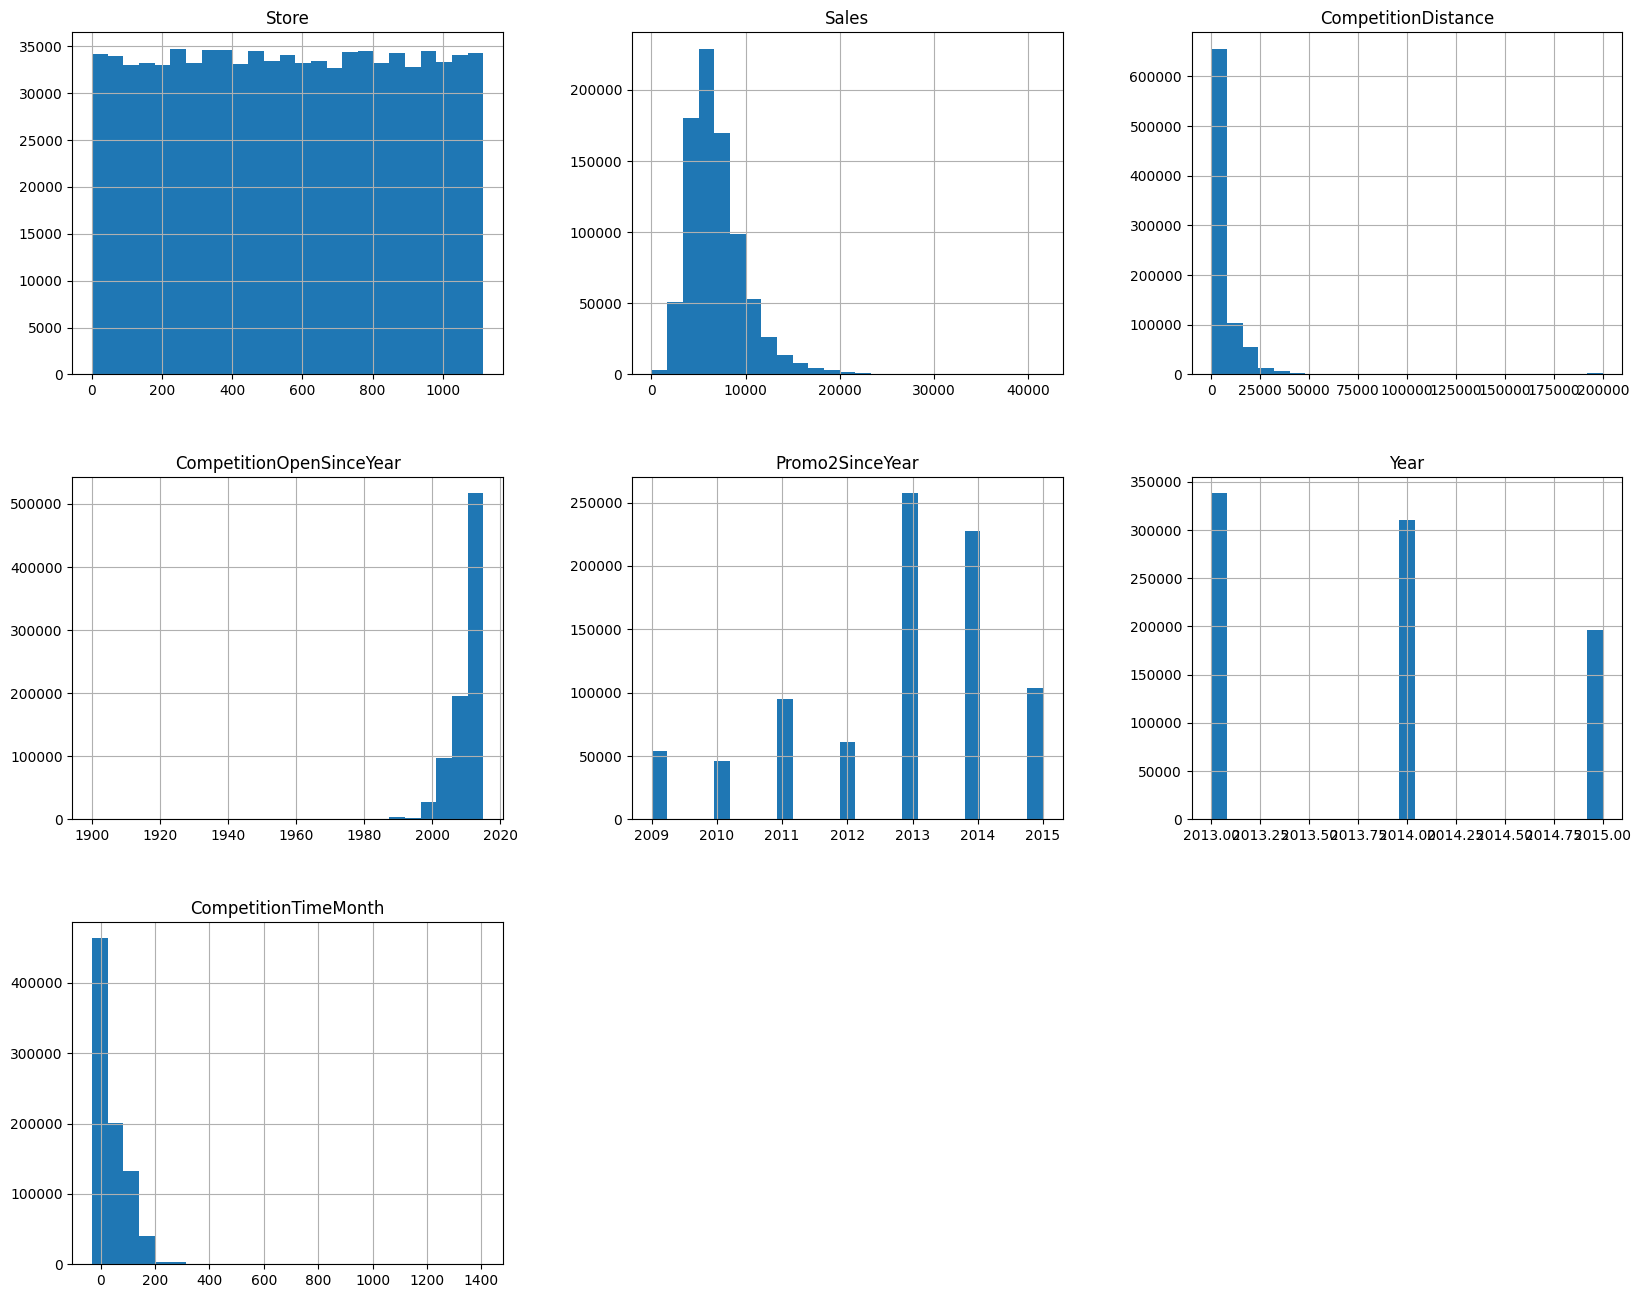

In [16]:
df_num.hist(bins=25)

### Valores Cíclicos

array([[<Axes: title={'center': 'DayOfWeek'}>,
        <Axes: title={'center': 'CompetitionOpenSinceMonth'}>,
        <Axes: title={'center': 'Promo2SinceWeek'}>],
       [<Axes: title={'center': 'Month'}>,
        <Axes: title={'center': 'Day'}>,
        <Axes: title={'center': 'WeekOfYear'}>],
       [<Axes: title={'center': 'DayOfYear'}>, <Axes: >, <Axes: >]],
      dtype=object)

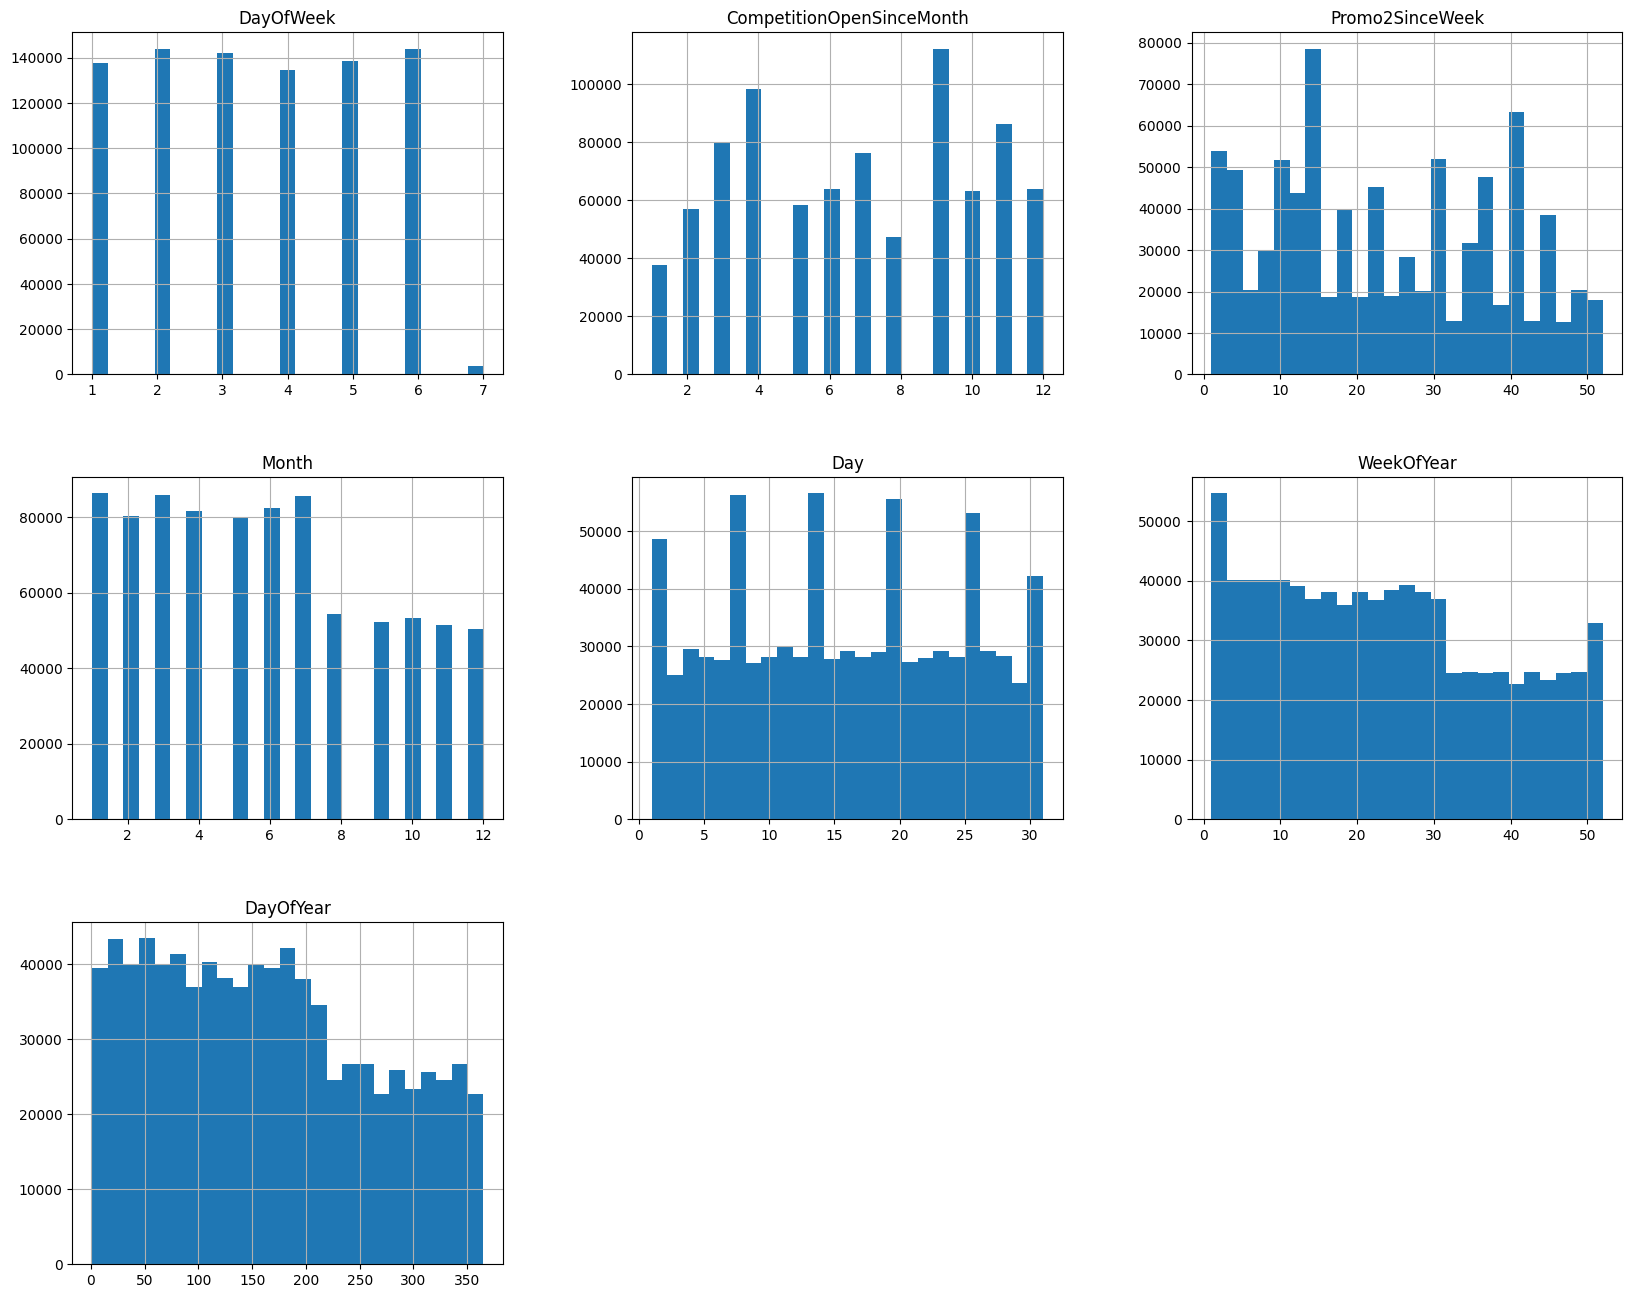

In [17]:
df_ciclic.hist(bins=25)

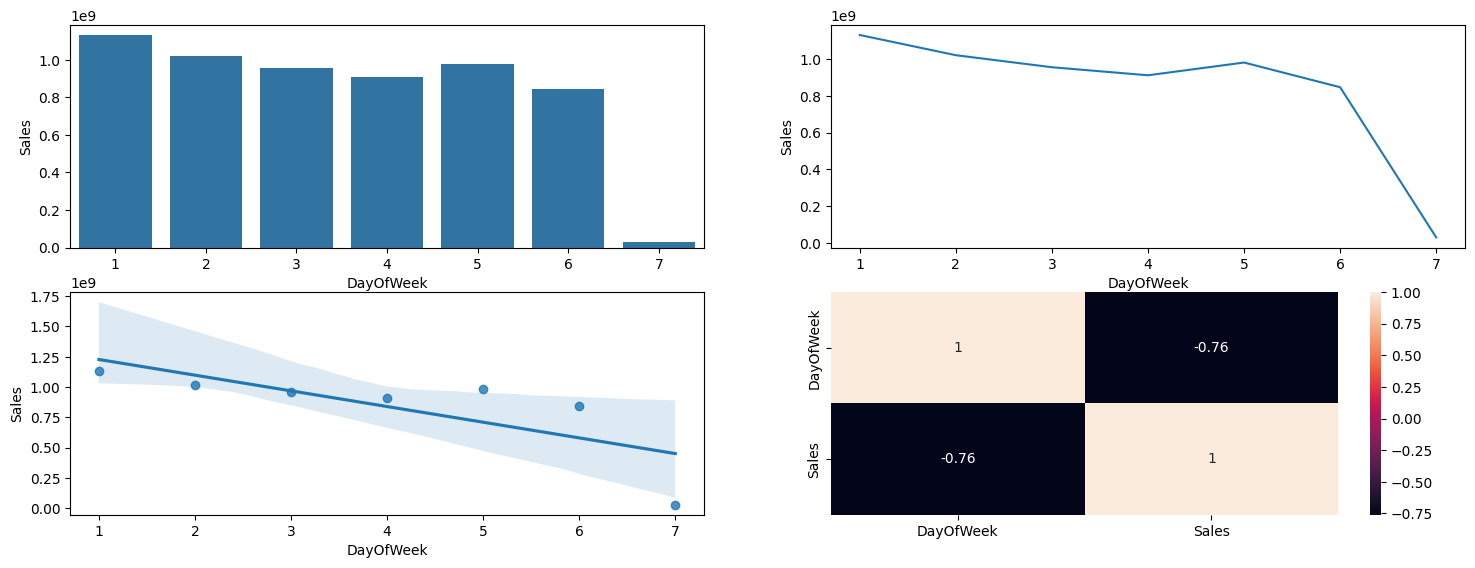

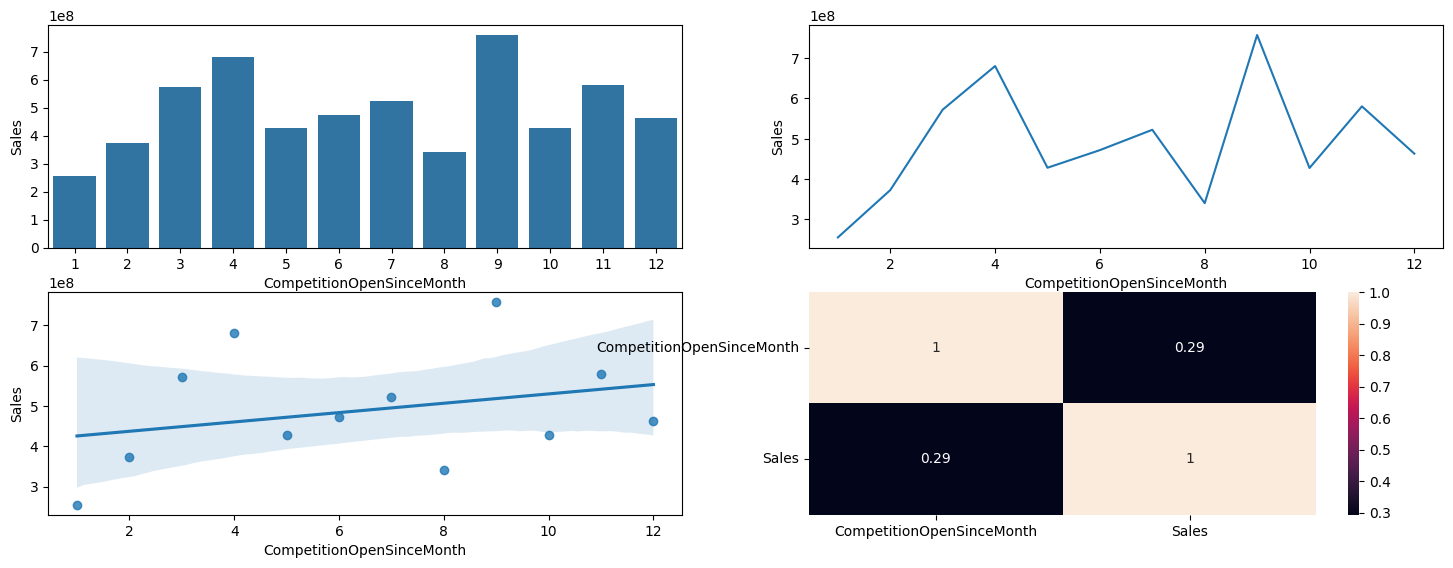

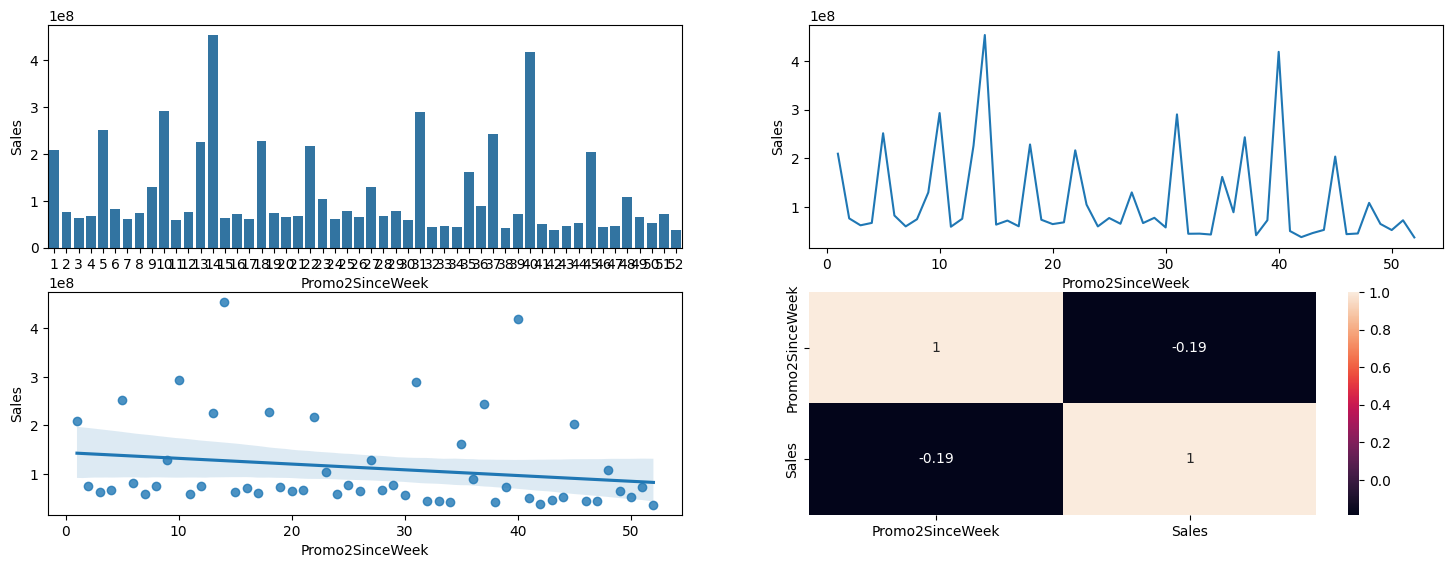

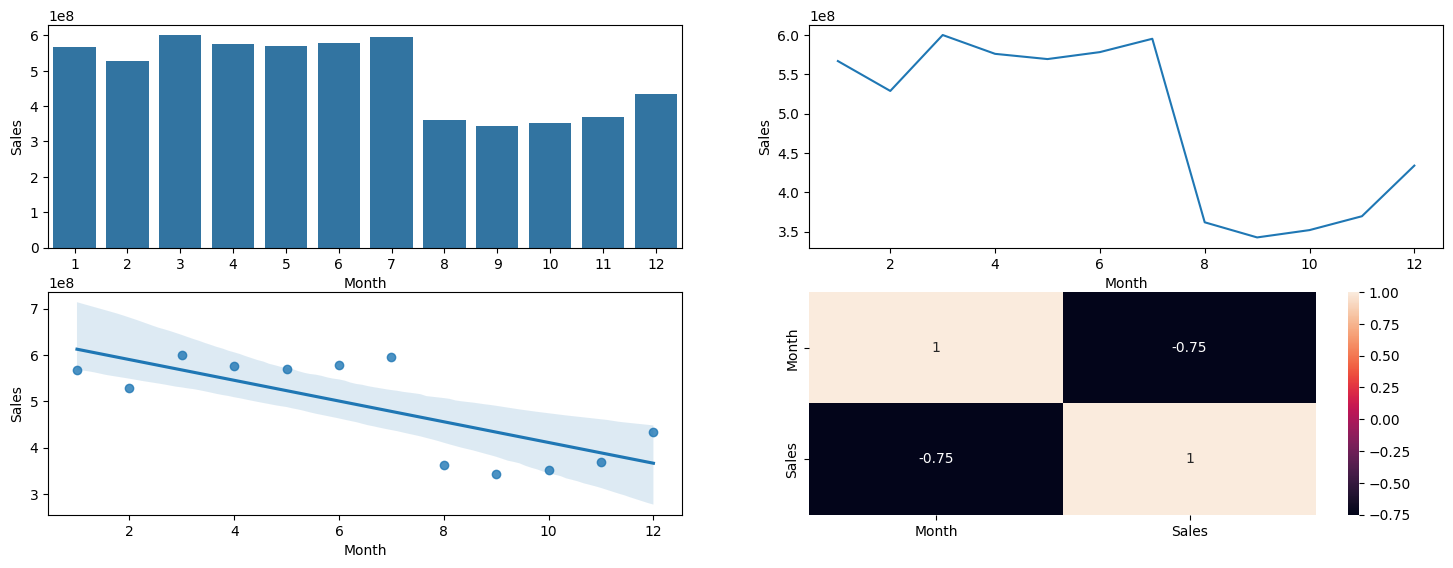

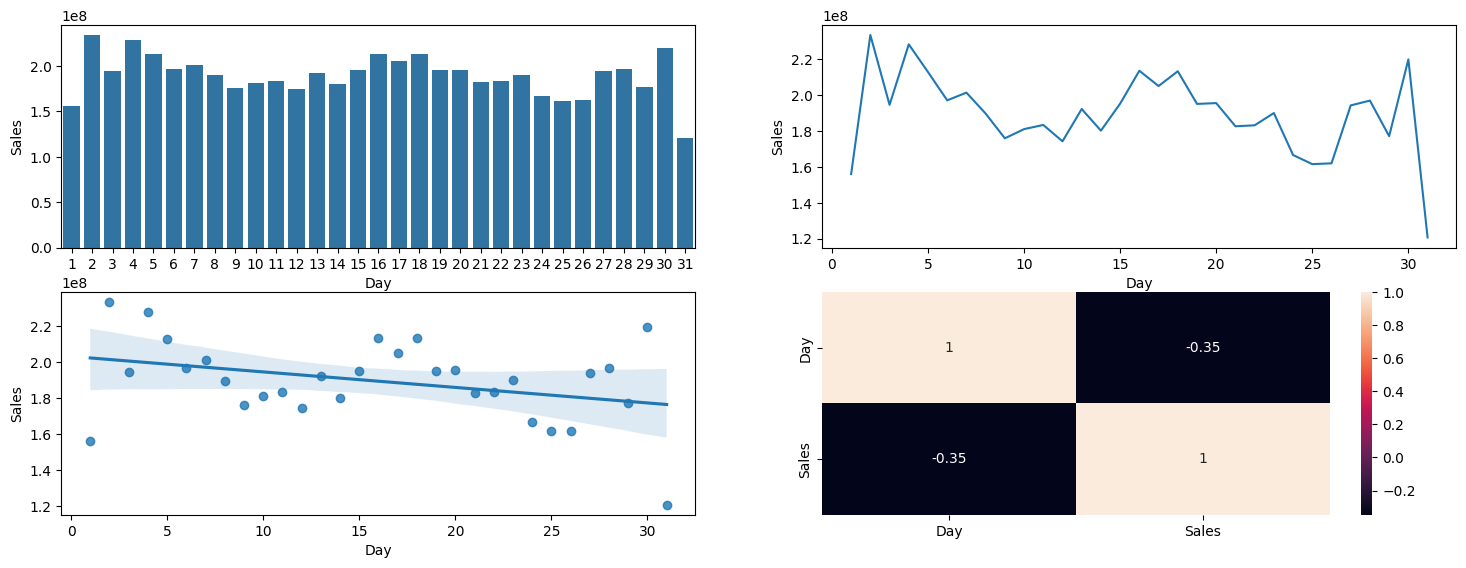

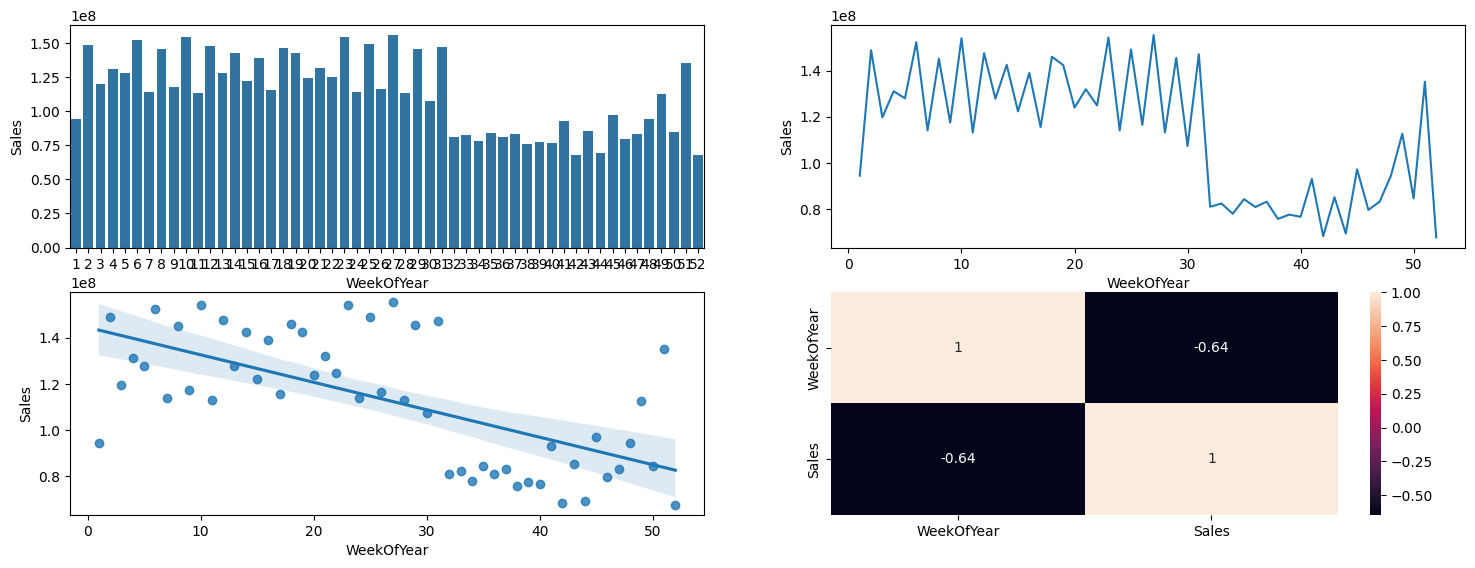

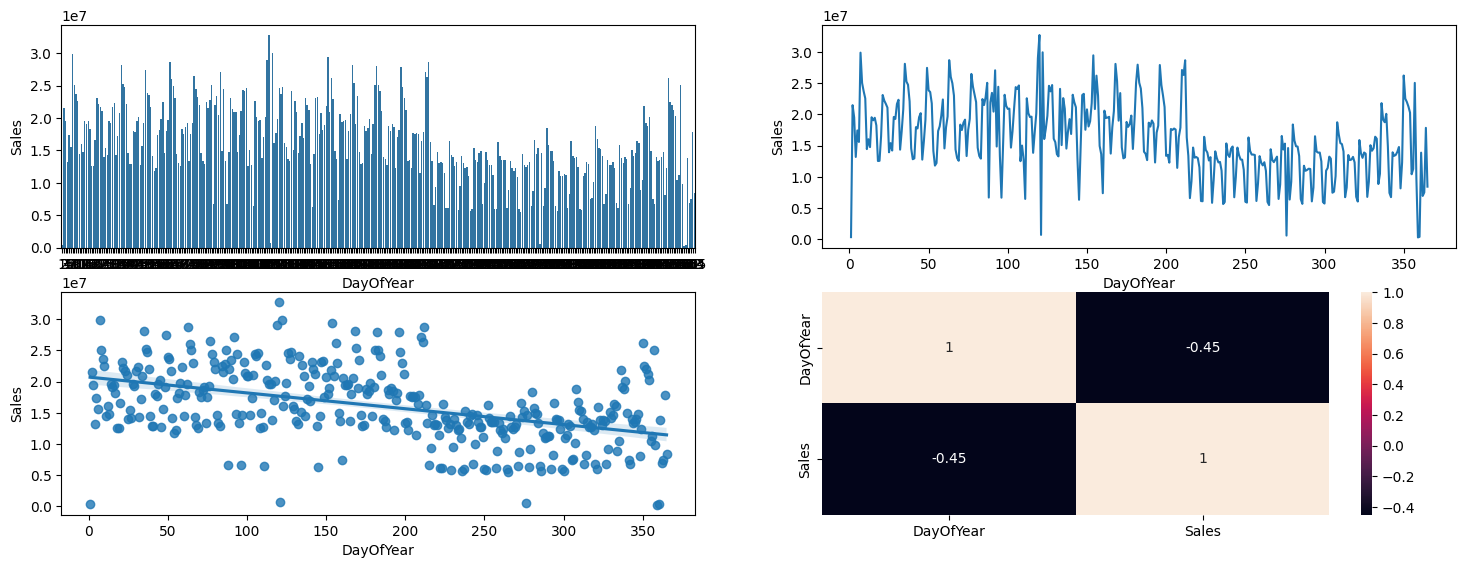

In [18]:
cols = df_ciclic.columns.tolist()
cols.append('Sales')
aux1 = df1[cols].copy()

r = len(df_ciclic.columns) * 2
c = 2

for index, col in enumerate(df_ciclic.columns):
    plt.figure(figsize=(18, 48))

    df_filtered = aux1[[col, 'Sales']]
    df_grouped = df_filtered.groupby(col).sum().reset_index()
    
    plt.subplot(r, c, 1)
    sns.barplot(data=df_grouped, x=col, y='Sales')

    plt.subplot(r, c, 2)
    sns.lineplot(data=df_grouped, x=col, y='Sales')

    plt.subplot(r, c, 3)
    sns.regplot(data = df_grouped, x = col, y = 'Sales');

    plt.subplot(r, c, 4)
    sns.heatmap(df_grouped.corr(method='pearson'), annot=True);

### Variável Resposta

<Axes: xlabel='Sales', ylabel='Count'>

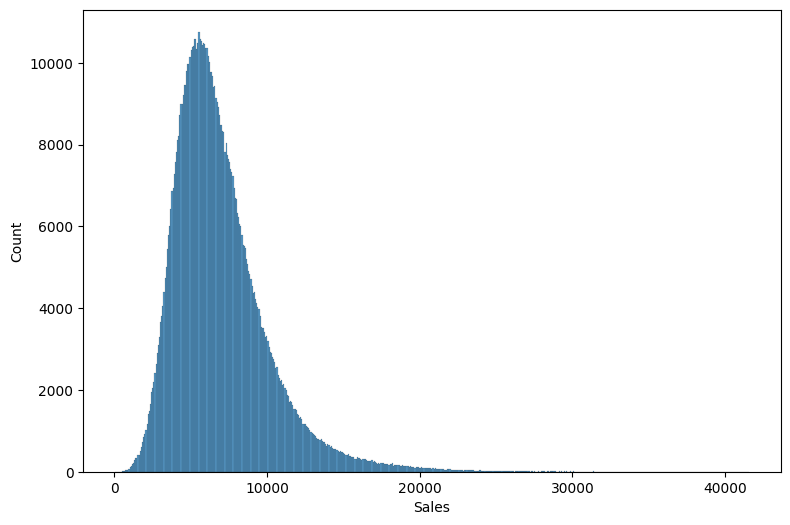

In [19]:
plt.figure(figsize=(9, 6))
sns.histplot(
    df1['Sales'], 
    kde = False
)

## Análise Bivariada e Validação das Hipóteses de Negócio

### 4. Unidades com variedade maior de produtos tendem a ter vendas mais elevadas.

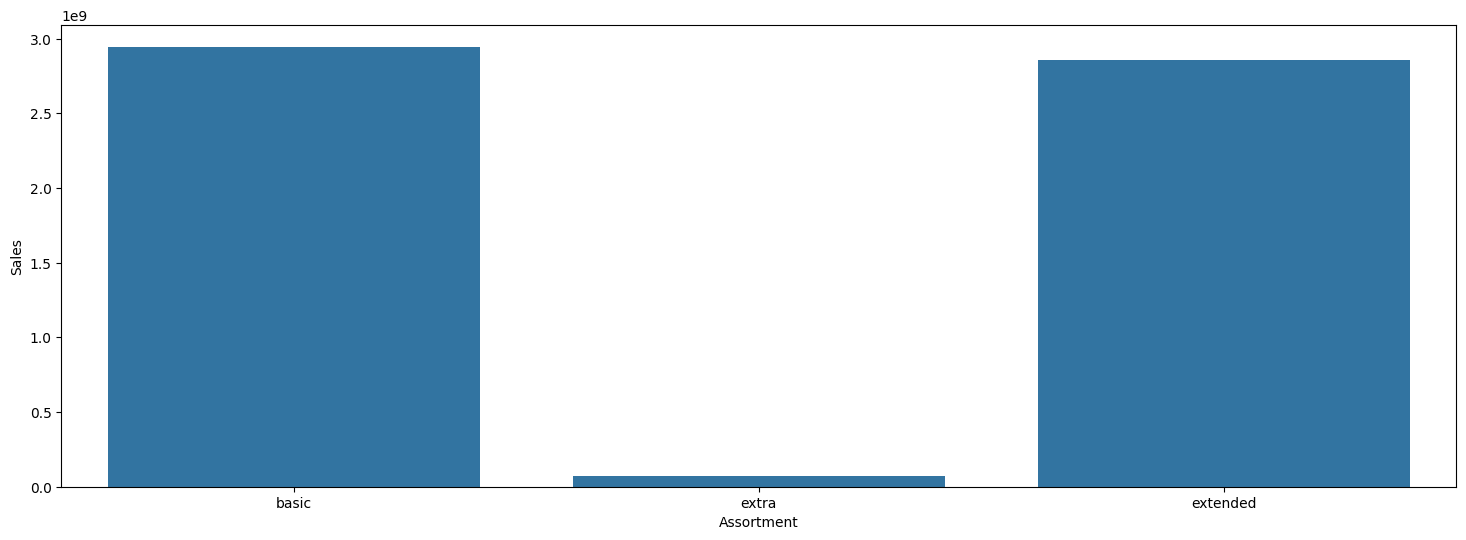

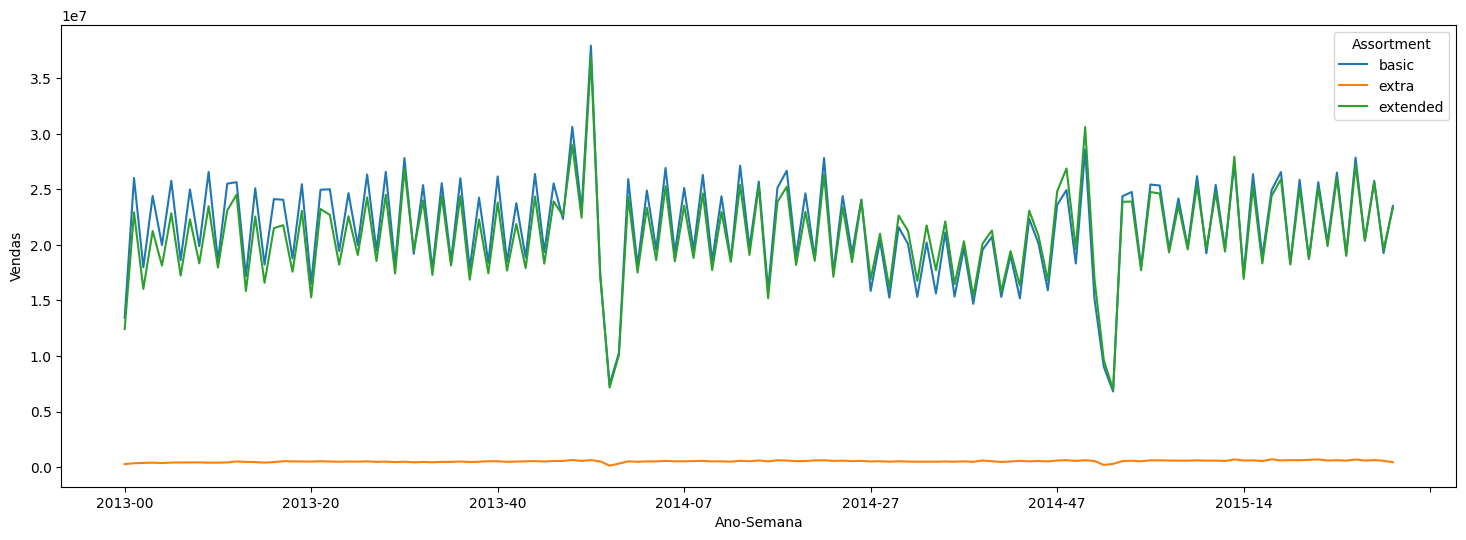

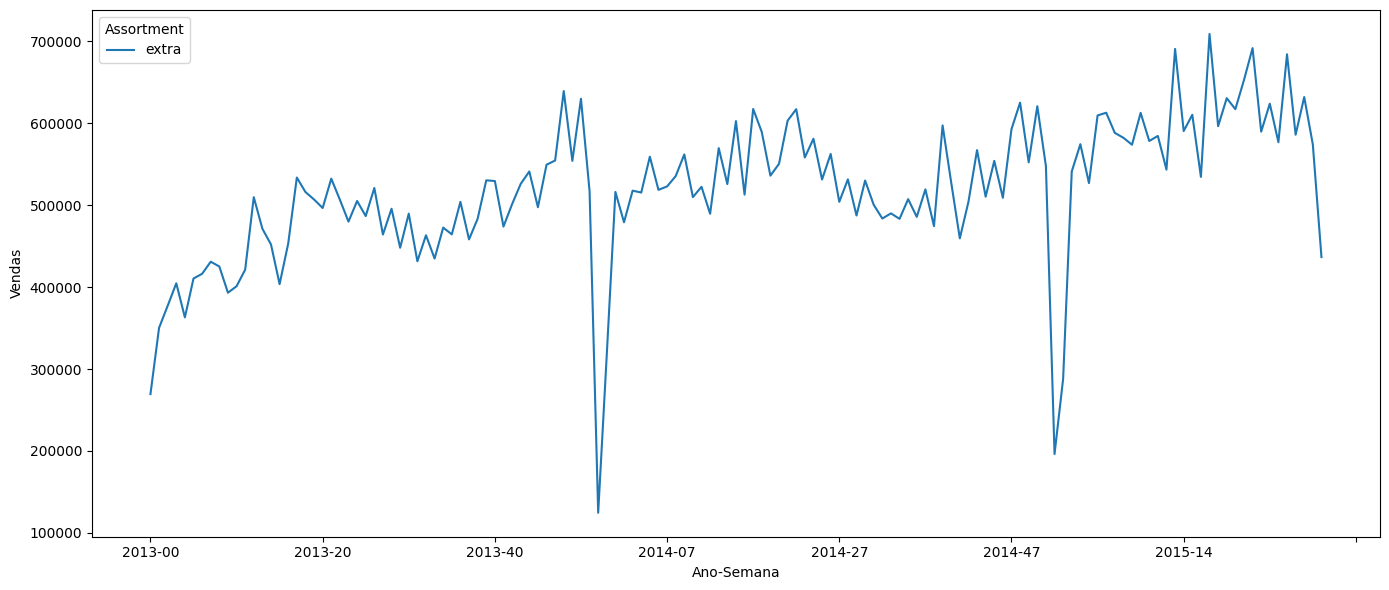

In [20]:
plt.figure(figsize=(18, 6))

aux1 = df1[['Assortment', 'Sales']].groupby( 'Assortment', observed=False).sum().reset_index()
sns.barplot(x='Assortment', y='Sales', data=aux1);
# reset_index() também transforma series em dataframe

aux2 = df1[[
    'YearWeek', 
    'Assortment', 
    'Sales'
]].groupby([
        'YearWeek',
        'Assortment'
    ], 
    observed=False).sum().reset_index()

# pivot = cada cor de linha representa um tipo de assortment diferente
df_pivot = aux2.pivot(index='YearWeek', columns='Assortment', values='Sales')
df_pivot.plot(figsize=(18, 6))
plt.xlabel('Ano-Semana')
plt.ylabel('Vendas')

aux3 = aux2[aux2['Assortment'] == 'extra']
df_pivot2 = aux3.pivot(
    index='YearWeek', 
    columns='Assortment', 
    values='Sales'
)
df_pivot2.plot(figsize=(14, 6))
plt.xlabel('Ano-Semana')
plt.ylabel('Vendas')
plt.tight_layout()
plt.show()

Resposta à Hipótese
> A hipótese de que unidades com maior variedade de produtos tendem a ter vendas mais elevadas não é totalmente confirmada pelos dados.
>
> - As lojas com variedade extended (maior variedade) não apresentam vendas significativamente superiores às lojas com variedade basic (menor variedade).
> - Ambas têm vendas muito superiores ao tipo extra, que apresenta vendas baixíssimas.
> - Portanto, não há uma relação clara e direta entre maior variedade de produtos e vendas mais elevadas neste conjunto de dados.

### 5. Lojas com competidores mais próximos vendem menos.

/var/folders/hr/m20wqrbs63d5q92wzv4hr1g00000gp/T/ipykernel_60723/312376057.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aux2 = aux1[['CompetitionDistanceBinned', 'Sales']].groupby('CompetitionDistanceBinned').sum().reset_index()


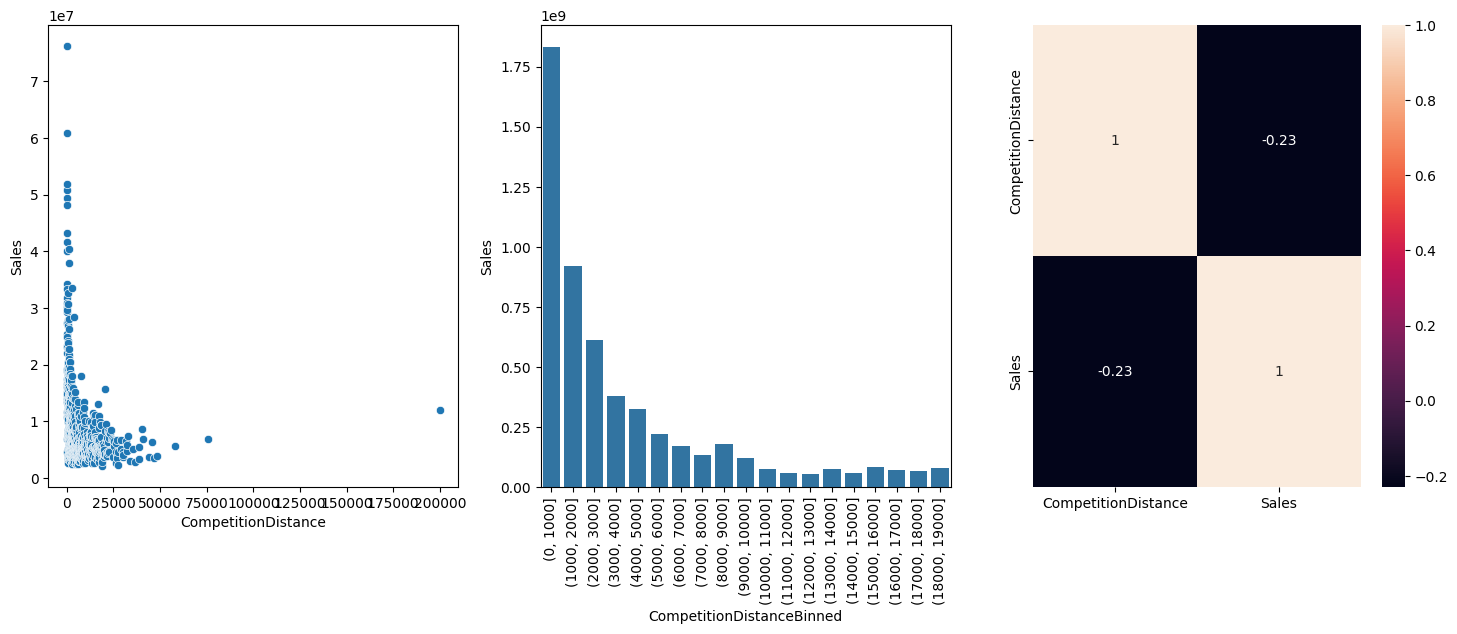

In [21]:
plt.figure(figsize=(18, 6))
aux1 = df1[['CompetitionDistance', 'Sales']].groupby('CompetitionDistance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x ='CompetitionDistance', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange( 0, 20000, 1000)) # cria um vetor que vai de 0 a 19000 (n-1), com passo de 1000 em 1000.
aux1['CompetitionDistanceBinned'] = pd.cut(aux1['CompetitionDistance'], bins=bins)
# cut: método que particiona o array de 1000 em 1000, ao invés de plotar um bin colado no outro
aux2 = aux1[['CompetitionDistanceBinned', 'Sales']].groupby('CompetitionDistanceBinned').sum().reset_index()
sns.barplot(x='CompetitionDistanceBinned', y='Sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson', numeric_only = True), annot=True);
bottom, top = x.get_ylim()

Resposta à Hipótese
> FALSO. A hipótese de que lojas com competidores mais distantes vendem mais é refutada pelos dados.
>
> Os gráficos mostram claramente o oposto: lojas com competidores mais próximos tendem a ter um volume de vendas total maior.
>
> A correlação negativa de -0.23, embora fraca, apoia essa conclusão, indicando que um aumento na distância está associado a uma leve diminuição nas vendas.

### 6. Lojas com competidores a mais tempo vendem mais.

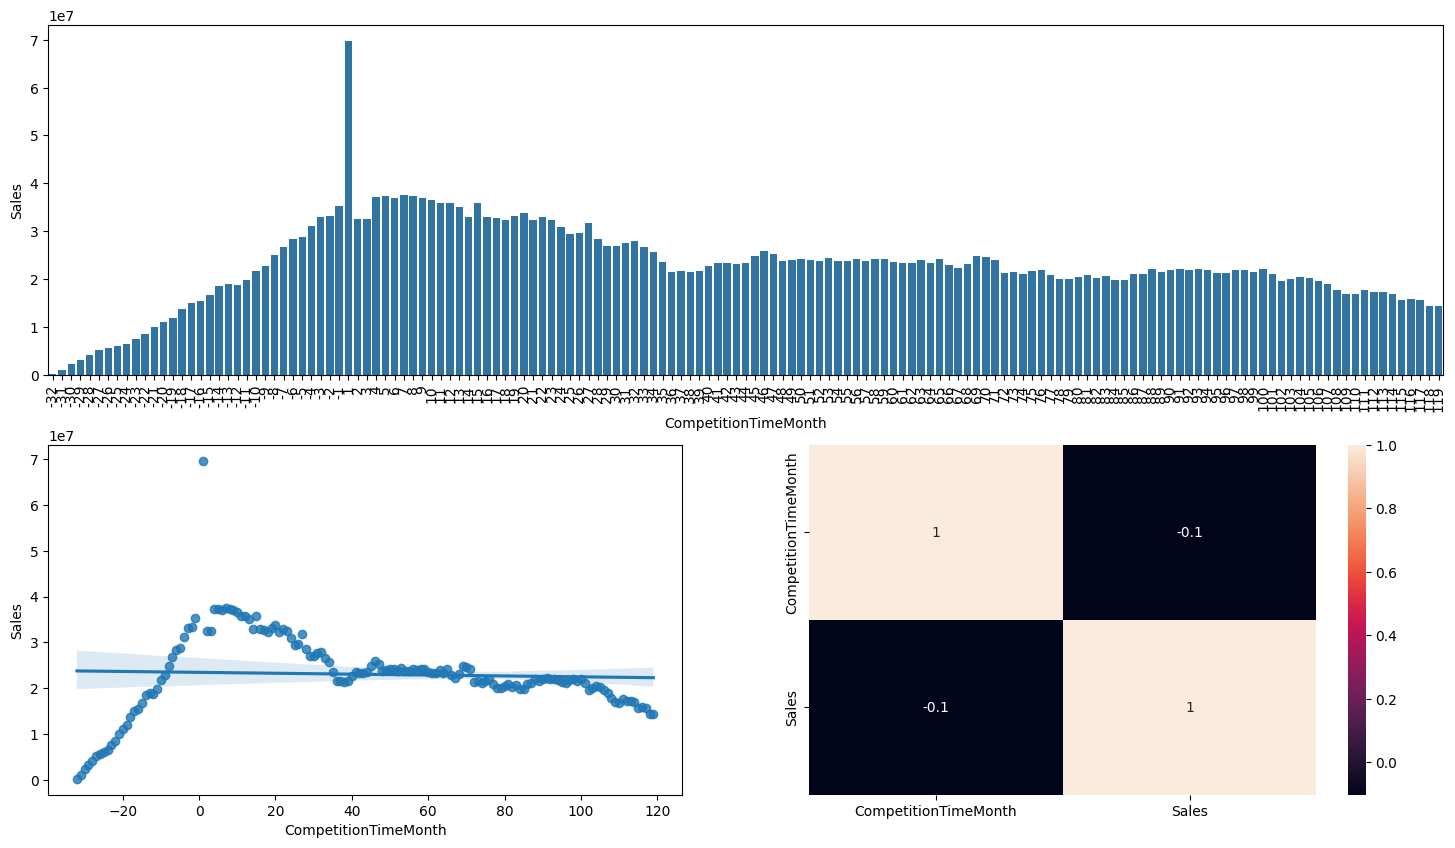

In [22]:
plt.figure(figsize=(18, 10))
aux1 = df1[['CompetitionTimeMonth', 'Sales']].groupby('CompetitionTimeMonth').sum().reset_index()
aux2 = aux1[(aux1['CompetitionTimeMonth'] < 120) & (aux1['CompetitionTimeMonth'] != 0)]
# != 0, pois se o CompetitionTimeMonth for 0 significa que a competição não teve 1 mês completo ainda.

grid = gridspec.GridSpec(2, 2)

plt.subplot(grid[0,:])
sns.barplot(x='CompetitionTimeMonth', y='Sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[1,0])
sns.regplot(x='CompetitionTimeMonth', y='Sales', data=aux2);

plt.subplot(grid[1,1])
sns.heatmap(aux1.corr(method='pearson'), annot=True);
bottom, top = x.get_ylim()

# Valores negativos indicam que a loja vendeu aquele evento/produto antes do período de competição ter iniciado.

Resposta à Hipótese
> A hipótese não é confirmada pelos dados.
> 
> Lojas com competidores há mais tempo não vendem mais. Na verdade, há uma leve tendência de queda nas vendas conforme o tempo de competição aumenta.
> 
> O pico de vendas ocorre próximo ao início da competição, mas depois as vendas caem ou se estabilizam.

### 11. Lojas com promoções ativas por mais tempo vendem mais.

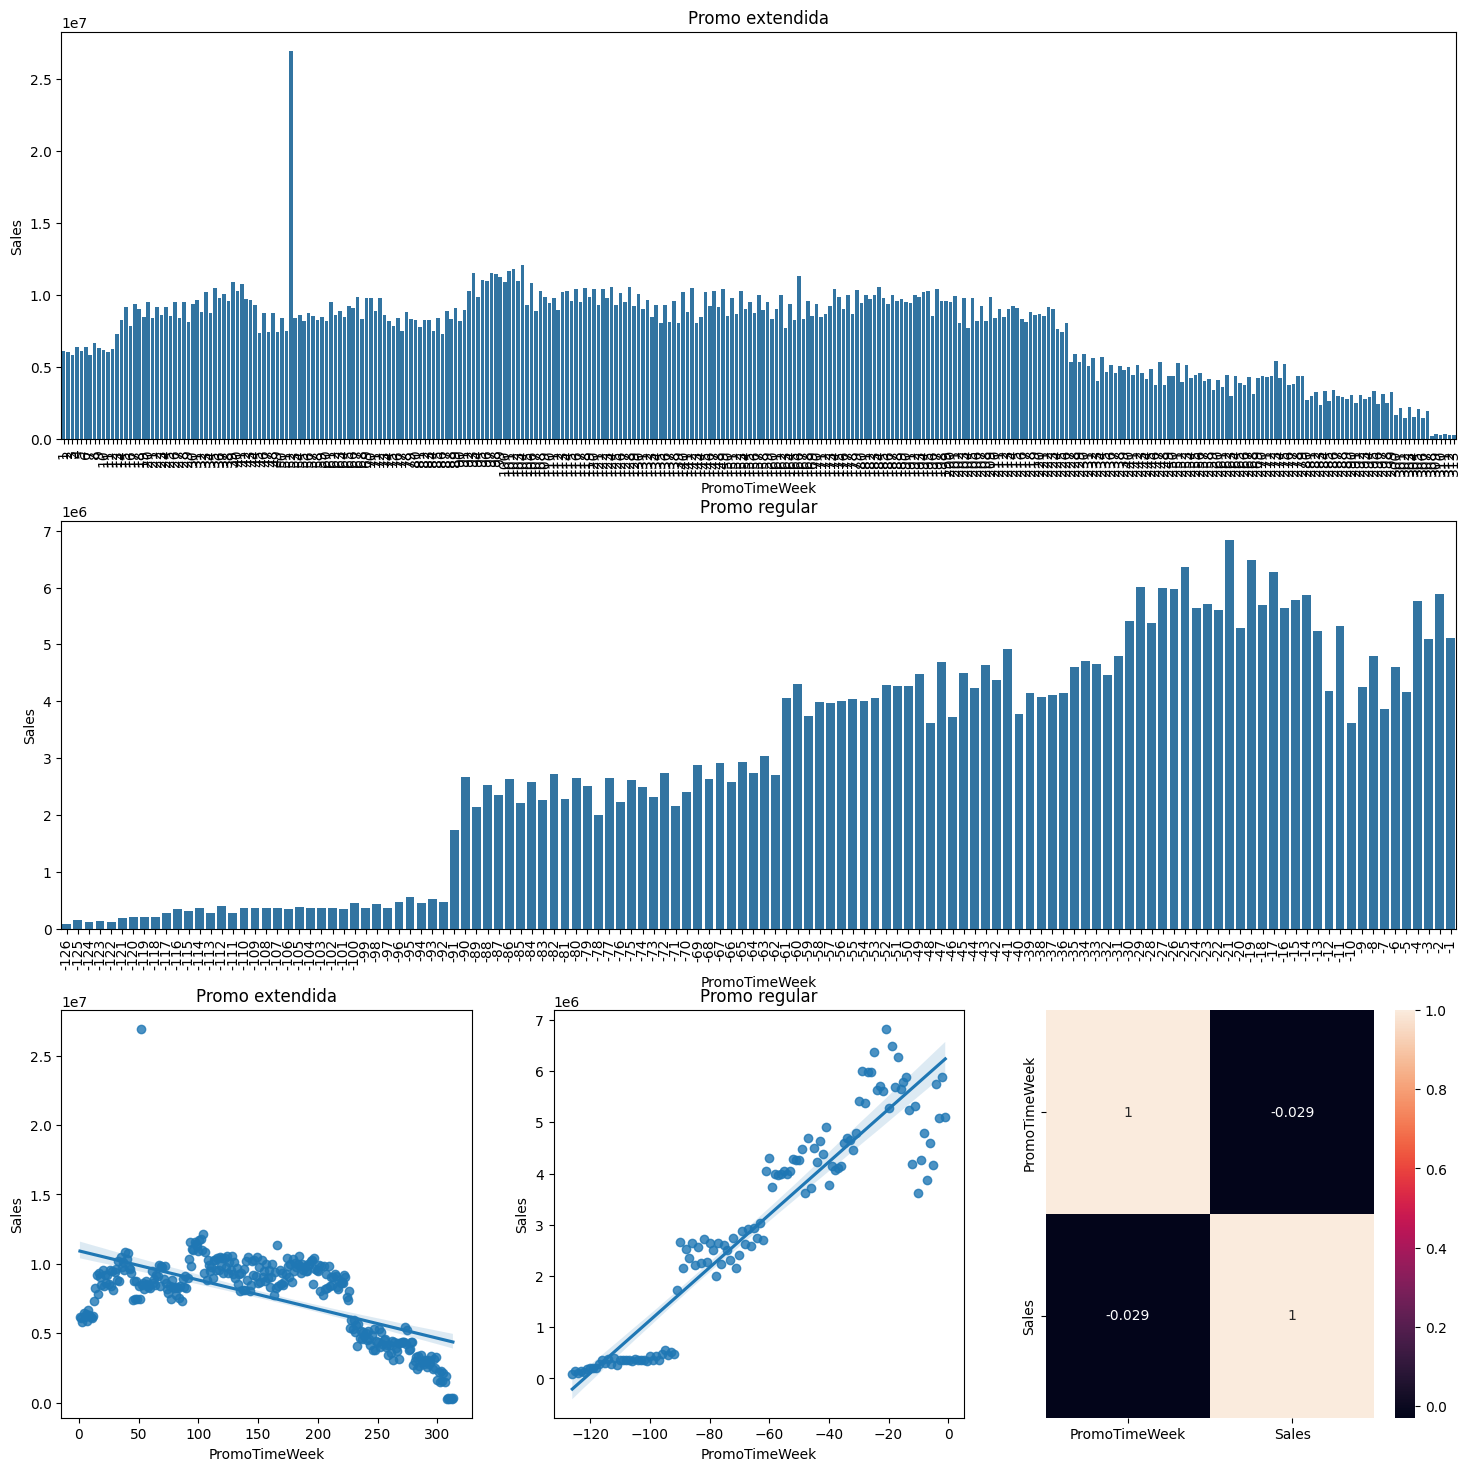

In [23]:
aux1 = df1[['PromoTimeWeek', 'Sales']].groupby('PromoTimeWeek').sum().reset_index()

grid = gridspec.GridSpec(3, 3)
plt.figure(figsize=(18, 18))

plt.subplot(grid[0,:])
aux2 = aux1[aux1['PromoTimeWeek'] > 0] # promo extendida
sns.barplot(x='PromoTimeWeek', y='Sales', data=aux2);
plt.xticks(rotation=90);
plt.title('Promo extendida');

plt.subplot(grid[1,:])
aux3 = aux1[aux1['PromoTimeWeek'] < 0] # promo regular
sns.barplot(x='PromoTimeWeek', y='Sales', data=aux3);
plt.xticks(rotation=90);
plt.title('Promo regular')

plt.subplot(grid[2,0])
sns.regplot(x='PromoTimeWeek', y='Sales', data=aux2);
plt.title('Promo extendida');

plt.subplot(grid[2,1])
sns.regplot(x='PromoTimeWeek', y='Sales', data=aux3);
plt.title('Promo regular')

plt.subplot(grid[2,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

# => 0, mostra as vendas totais por semana desde o início da promoção estendida.
# < 0, mostra as vendas totais por semana antes do início da promoção estendida (promoção regular).

Resposta à Hipótese
> A hipótese não é confirmada pelos dados.
>
> Lojas com promoções ativas por mais tempo não vendem mais. Na verdade, as vendas tendem a cair com o tempo de promoção estendida.
>
>O efeito positivo nas vendas ocorre próximo ao início da promoção, mas não se sustenta ao longo do tempo.


### 12. Lojas com mais dias de promoção vendem mais.

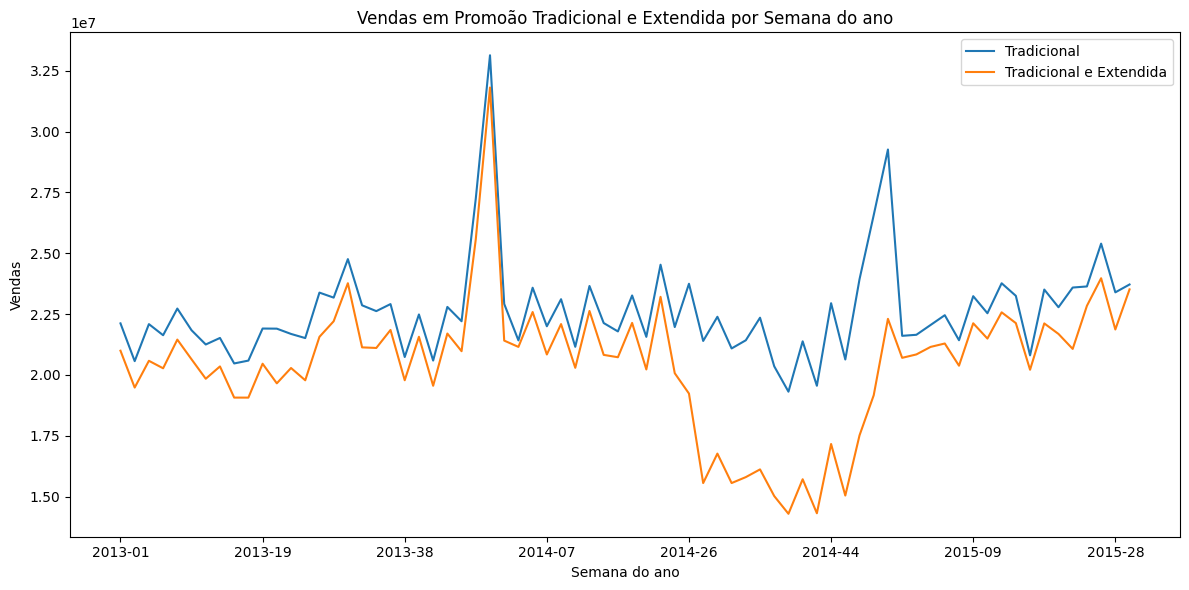

In [24]:
# Tradicional
aux2 = df1[(df1['Promo'] == 1) & (df1['Promo2'] == 1)][['YearWeek', 'Sales']] \
        .groupby('YearWeek').sum().reset_index()

# Tradicional e extendida
aux1 = df1[(df1['Promo'] == 1) & (df1['Promo2'] == 0)][['YearWeek', 'Sales']] \
        .groupby('YearWeek').sum().reset_index()

# Criar figura e eixo
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar as duas séries no mesmo gráfico
aux1.plot(x='YearWeek', y='Sales', ax=ax, label='Tradicional')
aux2.plot(x='YearWeek', y='Sales', ax=ax, label='Tradicional e Extendida')

# Ajustes estéticos
ax.set_xlabel('Semana do ano')
ax.set_ylabel('Vendas')
ax.set_title('Vendas em Promoão Tradicional e Extendida por Semana do ano')
ax.legend()

plt.tight_layout()
plt.show()

Resposta à Hipótese
> A hipótese não é confirmada pelos dados.
>
> Ter mais dias de promoção (ou mais tipos de promoção ativos ao mesmo tempo) não garante vendas maiores. Em muitos momentos, as vendas são até menores para lojas com mais dias de promoção.
>
> Isso pode indicar que o efeito das promoções se dilui ao longo do tempo, ou que promoções prolongadas perdem o impacto sobre os clientes.

### 14. Lojas que funcionam durante o Natal costumam vender mais.

Text(0.5, 1.0, 'Mediana de Vendas por Ano e Tipo de Feriado')

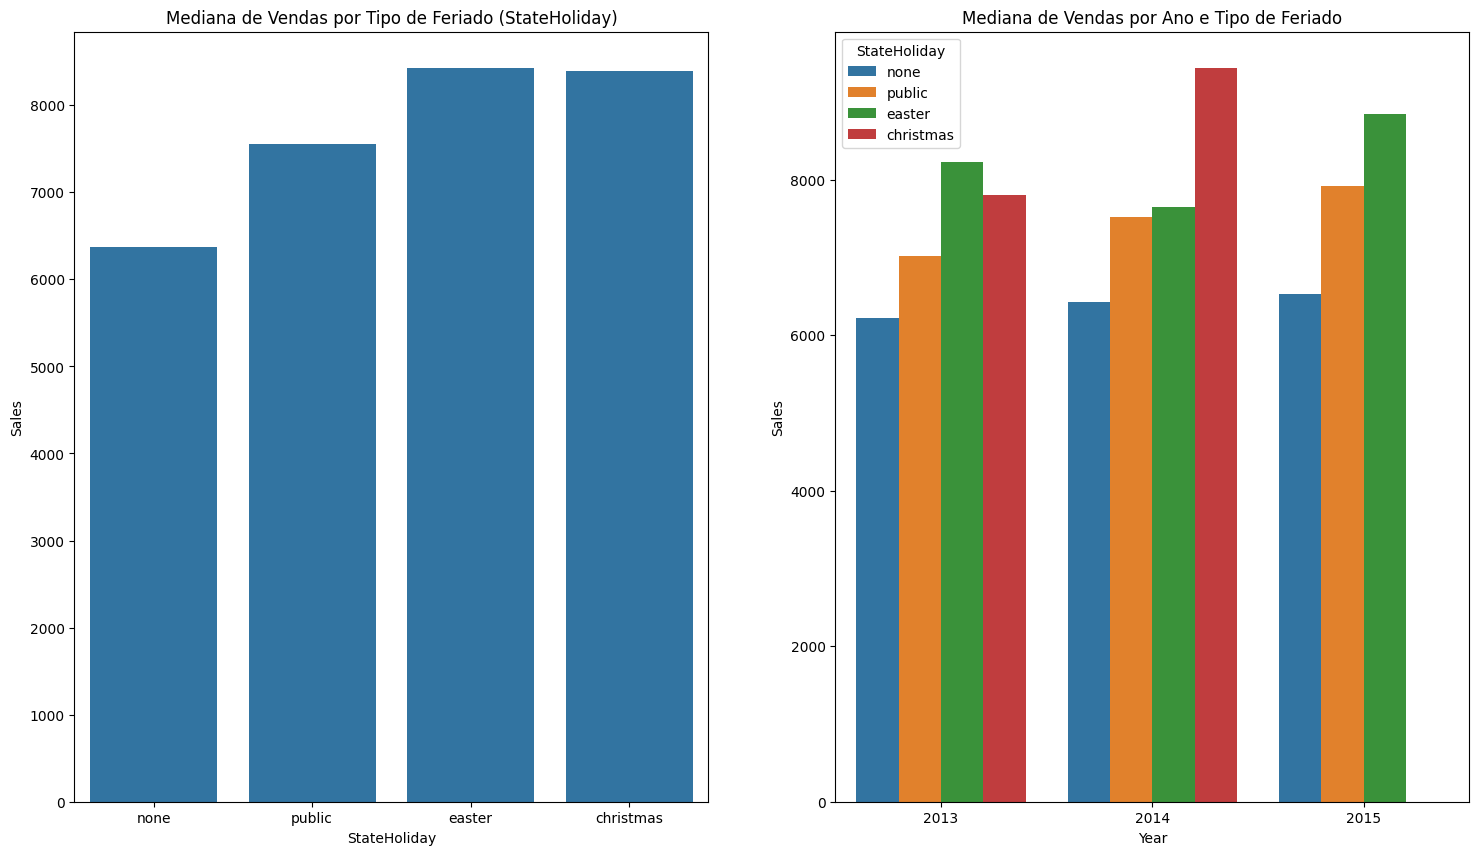

In [25]:
plt.figure(figsize=(18, 10))
aux = df1
plt.subplot( 1, 2, 1 )
aux1 = aux[['StateHoliday', 'Sales']].groupby('StateHoliday', observed=False).median().reset_index()
sns.barplot(x='StateHoliday', y='Sales', data=aux1);
plt.title('Mediana de Vendas por Tipo de Feriado (StateHoliday)');

plt.subplot( 1, 2, 2 )
aux2 = aux[['Year', 'StateHoliday', 'Sales']].groupby(['Year', 'StateHoliday'], observed=False ).median().reset_index()
sns.barplot(x='Year', y='Sales', hue='StateHoliday', data=aux2); # hue: indica qual coluna as barras serão agrupadas
plt.title('Mediana de Vendas por Ano e Tipo de Feriado')

Resposta à Hipótese
> A hipótese é confirmada pelos dados.
>
> Lojas que funcionam durante o Natal realmente costumam vender mais, apresentando as maiores medianas de vendas tanto na análise geral quanto segmentada por ano.

### 15. As vendas das lojas tendem a crescer ao longo dos anos.

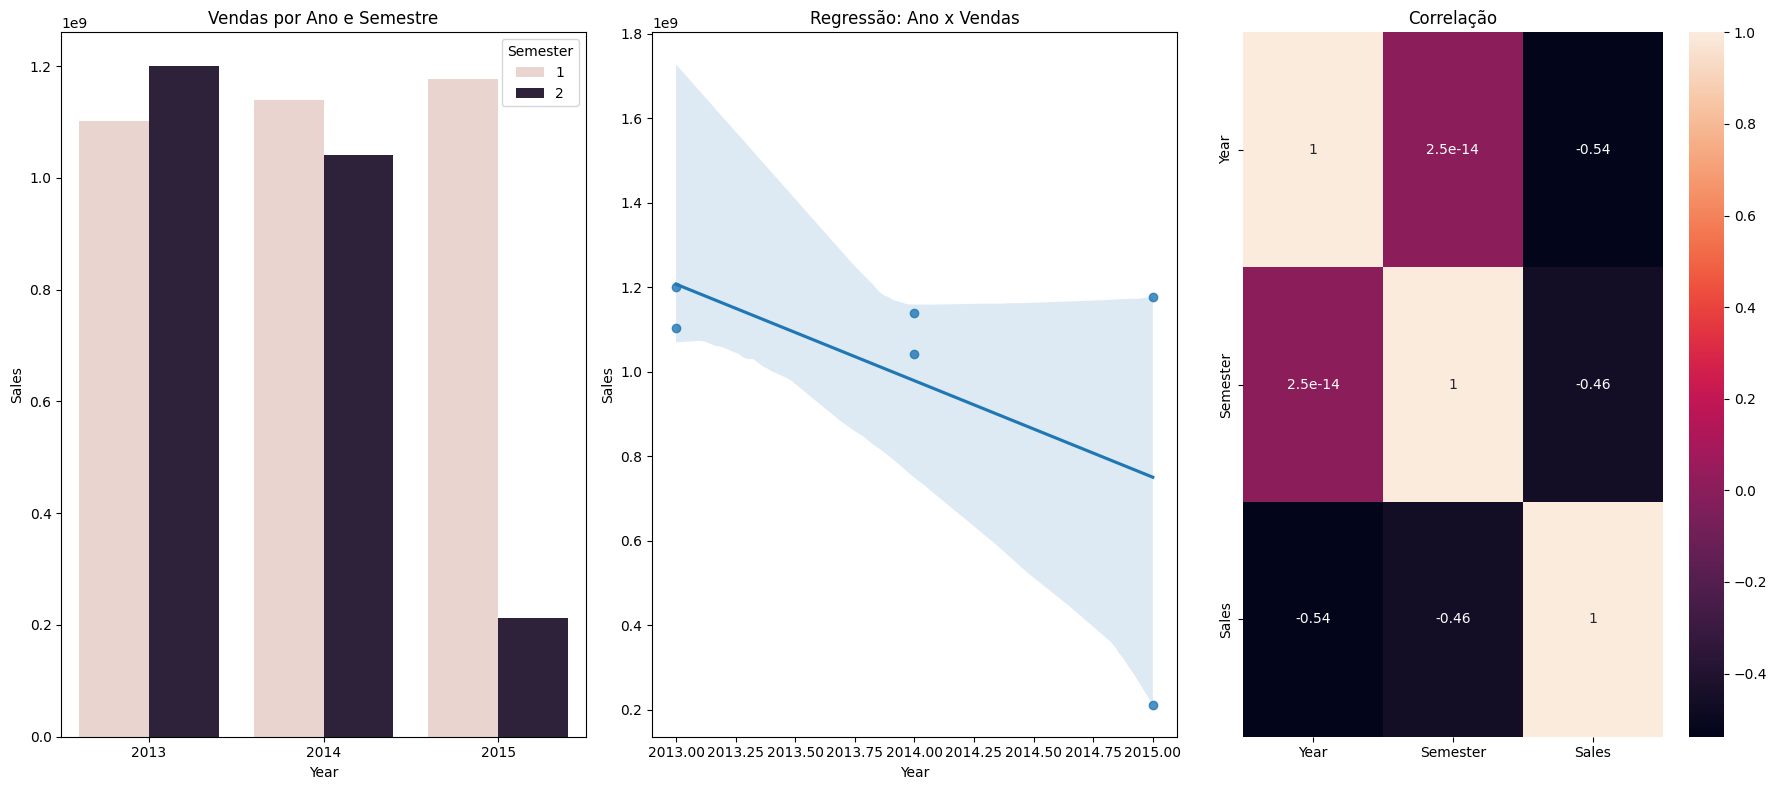

In [26]:
# Crie uma coluna de semestre
df1['Semester'] = df1['Date'].dt.month.apply(lambda x: 1 if x <= 6 else 2)

# Agrupe por ano e semestre, somando as vendas
aux1 = df1.groupby(['Year', 'Semester'])['Sales'].sum().reset_index()

plt.figure(figsize=(18, 8))

# Gráfico de barras: vendas por ano e semestre
plt.subplot(1, 3, 1)
sns.barplot(x='Year', y='Sales', hue='Semester', data=aux1)
plt.title('Vendas por Ano e Semestre')

# Gráfico de regressão: vendas por ano e semestre
plt.subplot(1, 3, 2)
sns.regplot(x='Year', y='Sales', data=aux1)
plt.title('Regressão: Ano x Vendas')

# Heatmap de correlação
plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(), annot=True)
plt.title('Correlação')

plt.tight_layout()
plt.show()

Resposta à Hipótese
> A hipótese não é confirmada pelos dados, pois o ano de 2015 está incompleto.
> 
> Considerando apenas o primeiro semestre de cada ano, há uma tendência de leve crescimento das vendas ao longo dos anos.
> 
> Olhando para o segundo semestre, de 2013 à 2014 há uma queda nas vendas, porém o ano de 2015, por estar incompleto, não pode ser comparado integralmente.

### 16. O volume de vendas costuma ser maior no segundo semestre.

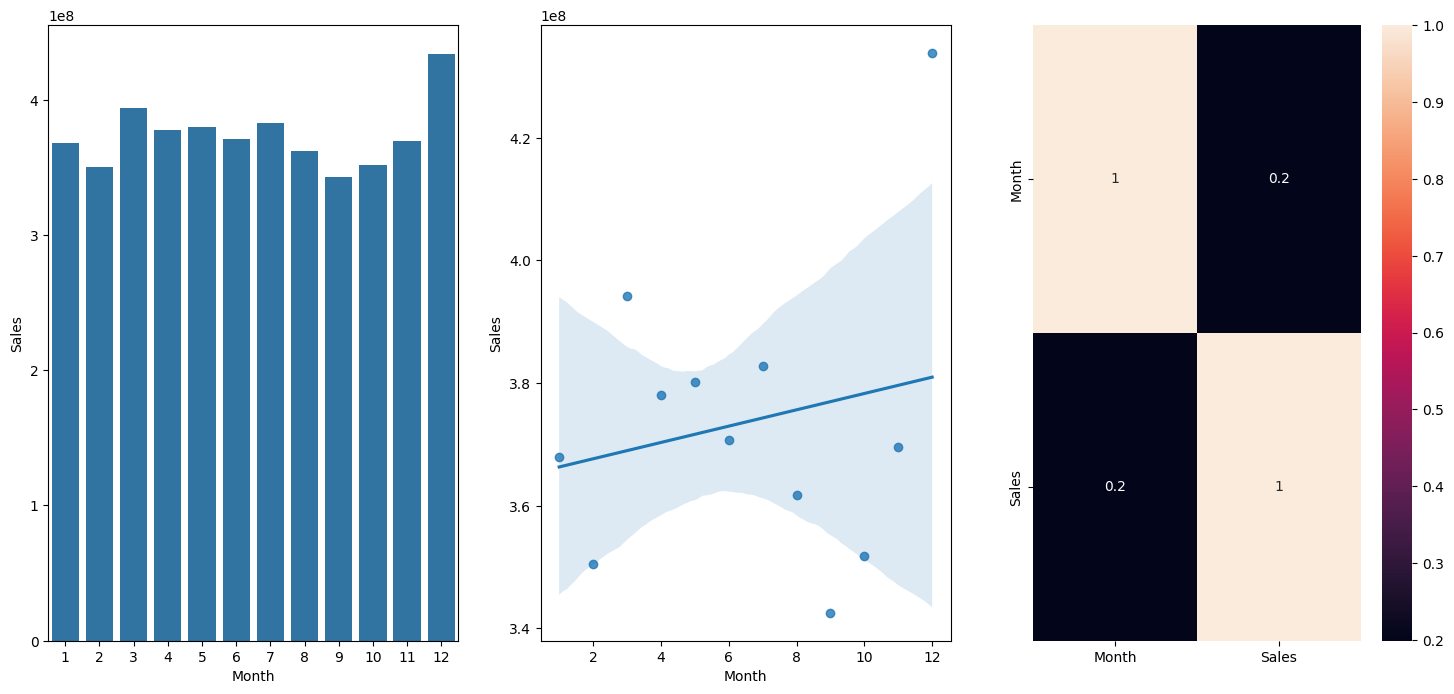

In [29]:
plt.figure(figsize=(18, 8))
aux_hip_month = df1[df1['Year'] != 2015] # Aqui já está sendo desconsiderado o ano de 2015
aux1 = aux_hip_month[['Month', 'Sales']].groupby('Month').sum().reset_index()

plt.subplot(1, 3, 1)
sns.barplot(x='Month', y='Sales', data=aux1);

plt.subplot(1, 3, 2)
sns.regplot(x='Month', y='Sales', data=aux1);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

Resposta à Hipótese
> A hipótese não é totalmente confirmada pelos dados.
>
> O volume de vendas não é consistentemente maior no segundo semestre, exceto pelo mês de dezembro, que apresenta um pico significativo (provavelmente devido ao Natal).
>
> Nos demais meses do segundo semestre, as vendas são similares ou até menores do que em alguns meses do primeiro semestre.
>
> A tendência geral ao longo do ano é de leve aumento, mas não é forte o suficiente para afirmar que o segundo semestre, como um todo, tem vendas maiores.

### 17. Após o dia 10 de cada mês, as vendas tendem a aumentar.

Text(0, 0.5, 'Média diária de vendas')

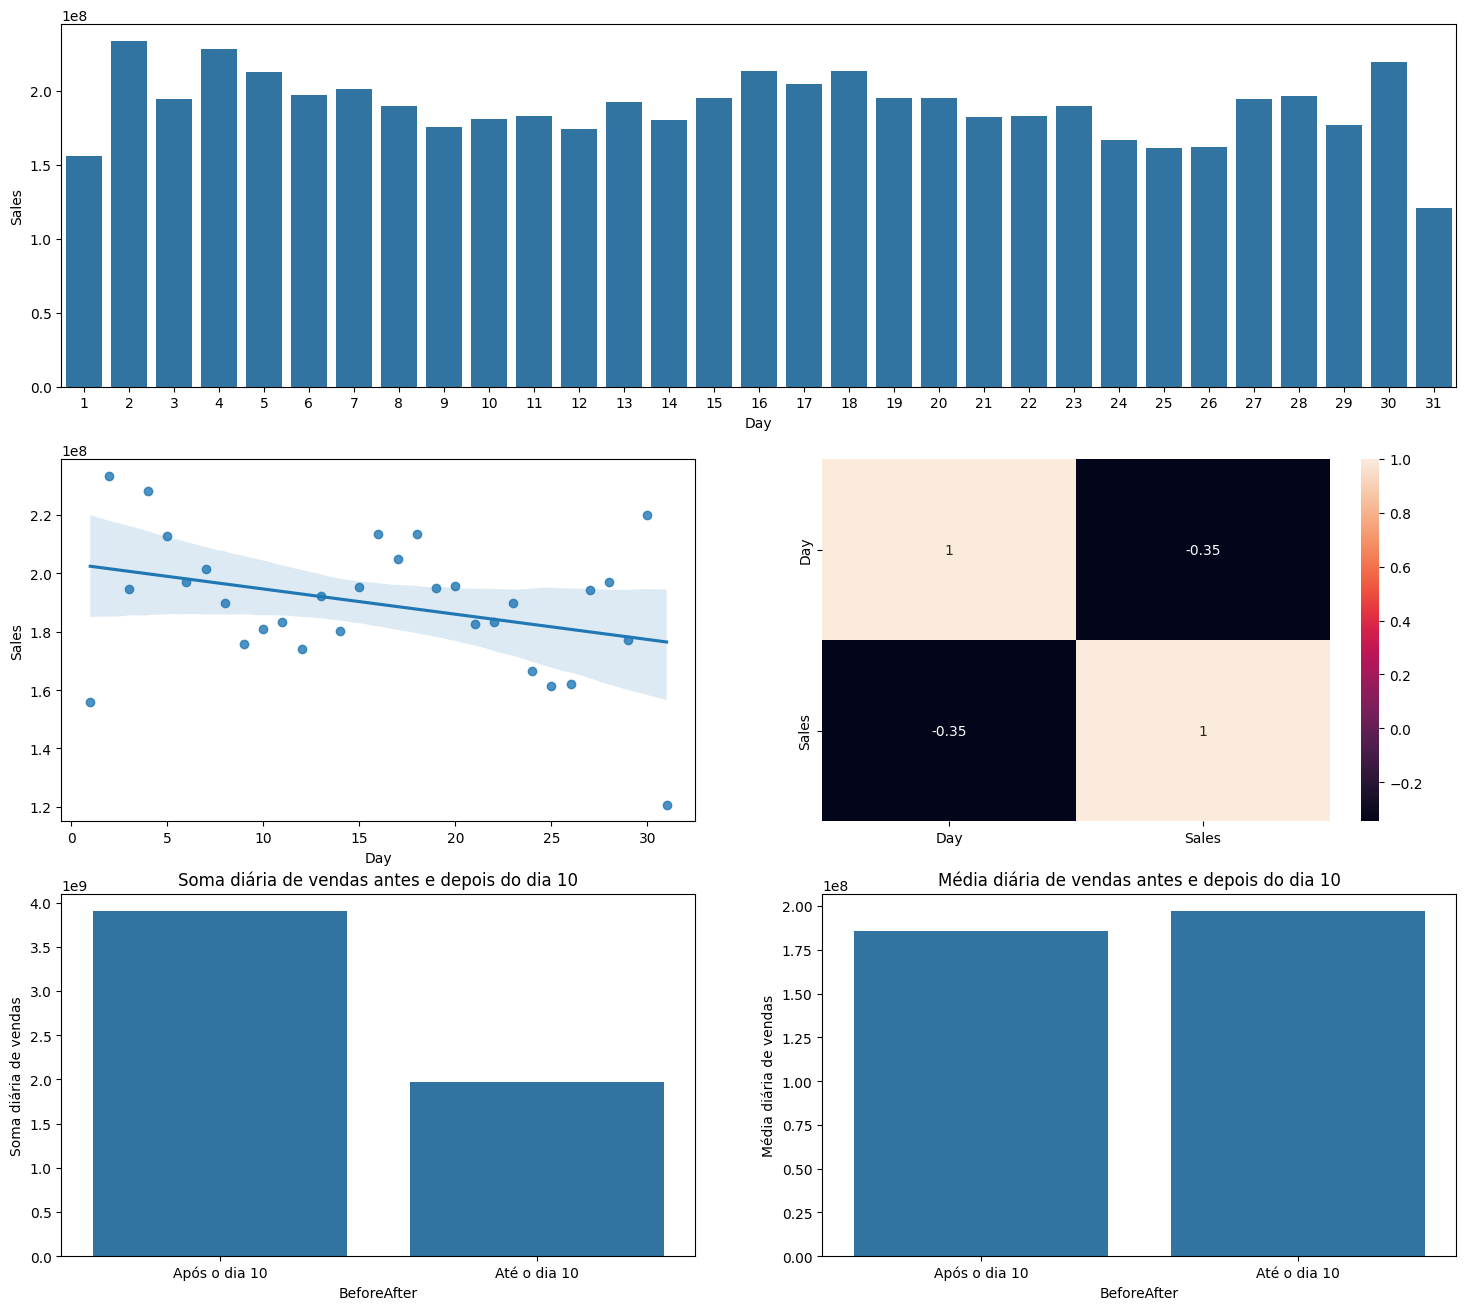

In [41]:
aux1 = df1[['Day', 'Sales']].groupby('Day').sum().reset_index()
aux1['BeforeAfter'] = aux1['Day'].apply(lambda x: 'Até o dia 10' if x <= 10 else 'Após o dia 10')
aux2 = aux1[['BeforeAfter', 'Sales']].groupby('BeforeAfter').sum().reset_index()
aux3 = aux1[['BeforeAfter', 'Sales']].groupby('BeforeAfter').mean().reset_index()

plt.figure(figsize=(18, 16))
grid = gridspec.GridSpec(3, 2)

plt.subplot(grid[0,:])
sns.barplot(x='Day', y='Sales', data=aux1);

plt.subplot(grid[1,0])
sns.regplot( x='Day', y='Sales', data=aux1);

plt.subplot(grid[1,1])
sns.heatmap(aux1[['Day', 'Sales']].corr(method='pearson'), annot=True);

plt.subplot(grid[2,0])
sns.barplot(x='BeforeAfter', y='Sales', data=aux2);
plt.title('Soma diária de vendas antes e depois do dia 10')
plt.ylabel('Soma diária de vendas')

plt.subplot(grid[2,1])
sns.barplot(x='BeforeAfter', y='Sales', data=aux3);
plt.title('Média diária de vendas antes e depois do dia 10')
plt.ylabel('Média diária de vendas')

Resposta à Hipótese
> A hipótese de que as vendas aumentam após o dia 10 não é confirmada.
>
> O gráfico de média diária mostra que as vendas permanecem estáveis antes e depois do dia 10, sem aumento significativo.
>
> O total acumulado após o dia 10 é maior apenas porque há mais dias nesse intervalo, não porque as vendas diárias aumentam.

### 18. Lojas vendem menos aos finais de semana.

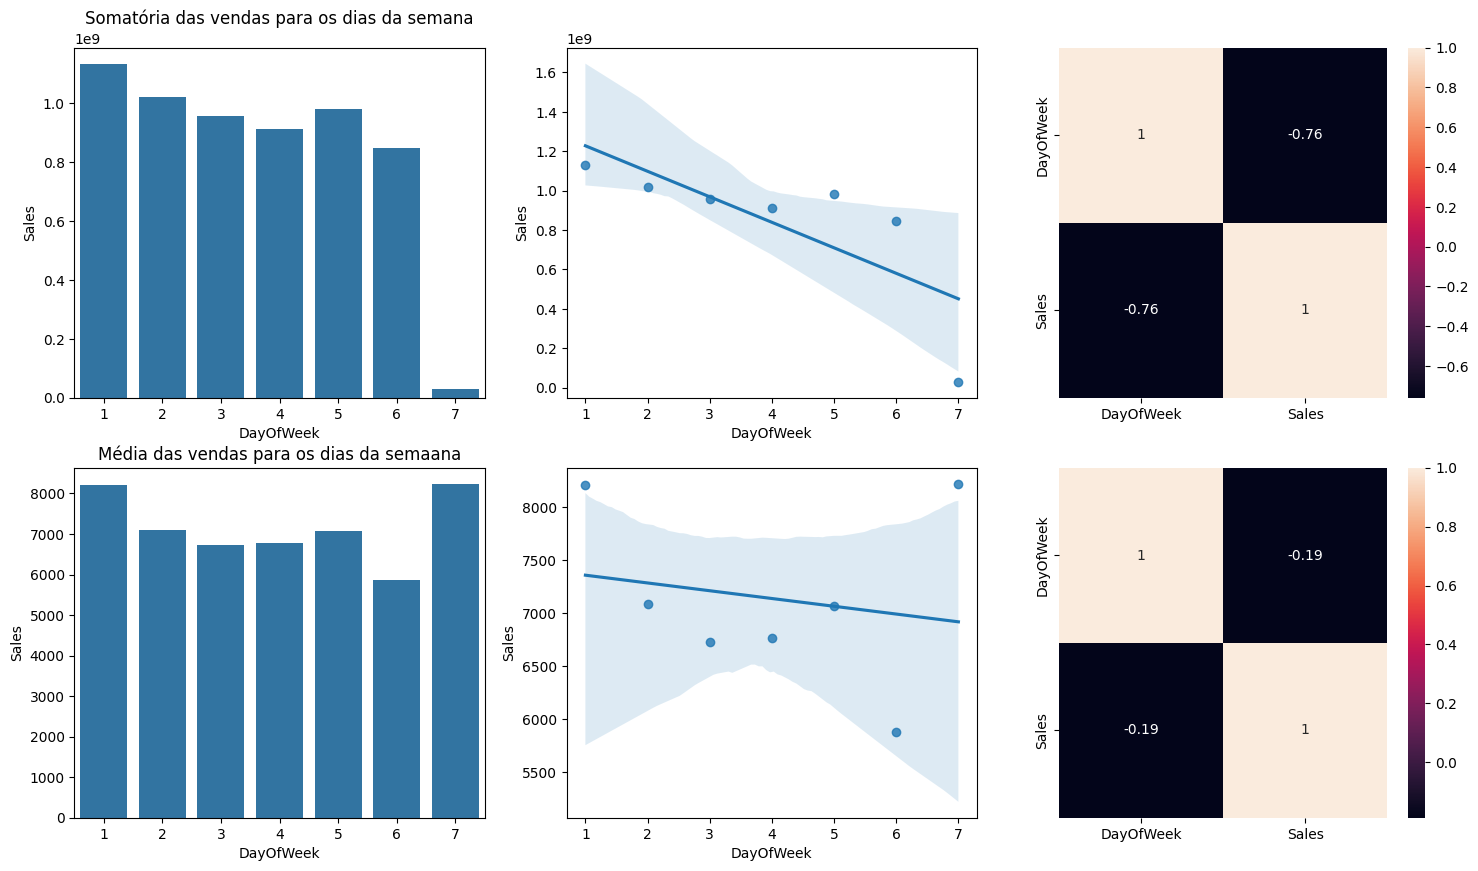

In [42]:
aux1 = df1[['DayOfWeek', 'Sales']].groupby('DayOfWeek').sum().reset_index()
aux2 = df1[['DayOfWeek', 'Sales']].groupby('DayOfWeek').mean().reset_index()

plt.figure(figsize=(18, 10))
plt.subplot(2, 3, 1)
sns.barplot(x='DayOfWeek', y='Sales', data=aux1);
plt.title('Somatória das vendas para os dias da semana')

plt.subplot(2, 3, 2)
sns.regplot(x='DayOfWeek', y='Sales', data=aux1);

plt.subplot(2, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

plt.subplot(2, 3, 4)
sns.barplot(x='DayOfWeek', y='Sales', data=aux2);
plt.title('Média das vendas para os dias da semaana')

plt.subplot(2, 3, 5)
sns.regplot(x='DayOfWeek', y='Sales', data=aux2);

plt.subplot(2, 3, 6)
sns.heatmap(aux2.corr(method='pearson'), annot=True);

Resposta à Hipótese
> Sobre o volume total de vendas para cada dia da semana (1 = segunda-feira, ..., 7 = domingo), nota-se que o domingo (7) apresenta um volume de vendas muito inferior aos demais dias, enquanto o sábado (6) também tem vendas menores em relação aos dias úteis. Os maiores volumes de vendas ocorrem no início da semana (segunda e terça-feira).
>
> As vendas caem significativamente nos finais de semana, especialmente no domingo, confirmando a hipótese.
>
> Os gráficos de dispersão e os mapas de calor reforçam essa queda nas vendas quando se aproxima do final de semana.

> Apesar do volume total de vendas ser menor no domingo, a média de vendas por loja aberta nesse dia é a mais alta. Isso sugere que, embora menos lojas estejam abertas aos domingos, aquelas que abrem conseguem vender mais, possivelmente devido a menor concorrência ou maior fluxo de clientes concentrado.
>
> Os dados sustentam parcialmente a hipótese. O volume total de vendas cai significativamente nos finais de semana, especialmente no domingo. No entanto, a média de vendas por loja aberta no domingo é a mais alta da semana, indicando que as lojas que abrem nesse dia têm desempenho superior.


### 19. Durante os períodos de férias escolares, as vendas costumam ser menores.

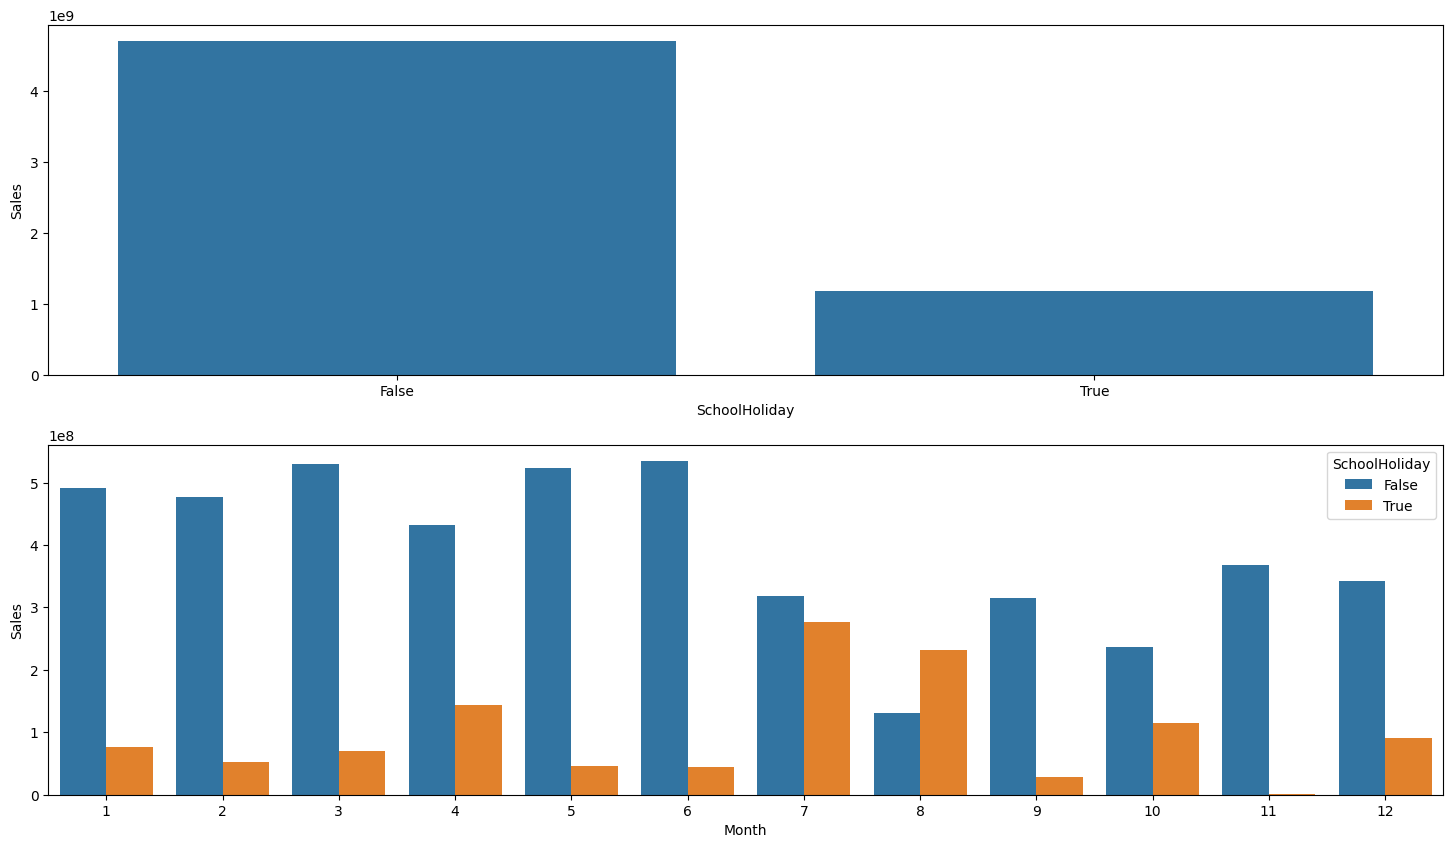

In [43]:
aux1 = df1[['SchoolHoliday', 'Sales']].groupby('SchoolHoliday').sum().reset_index()
aux2 = df1[['Month', 'SchoolHoliday', 'Sales']].groupby(['Month','SchoolHoliday']).sum().reset_index()

plt.figure(figsize=(18, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='SchoolHoliday', y='Sales', data=aux1);

plt.subplot(2, 1, 2)
sns.barplot(x='Month', y='Sales', hue='SchoolHoliday', data=aux2);

Resposta à Hipótese
> A hipótese é valida: os gráficos mostram que, de modo geral, durante os períodos de férias escolares, as vendas são menores em comparação com os períodos normais.


## Análises de Correlação

### Matriz de Correlação de Pearson das Variáveis Numéricas

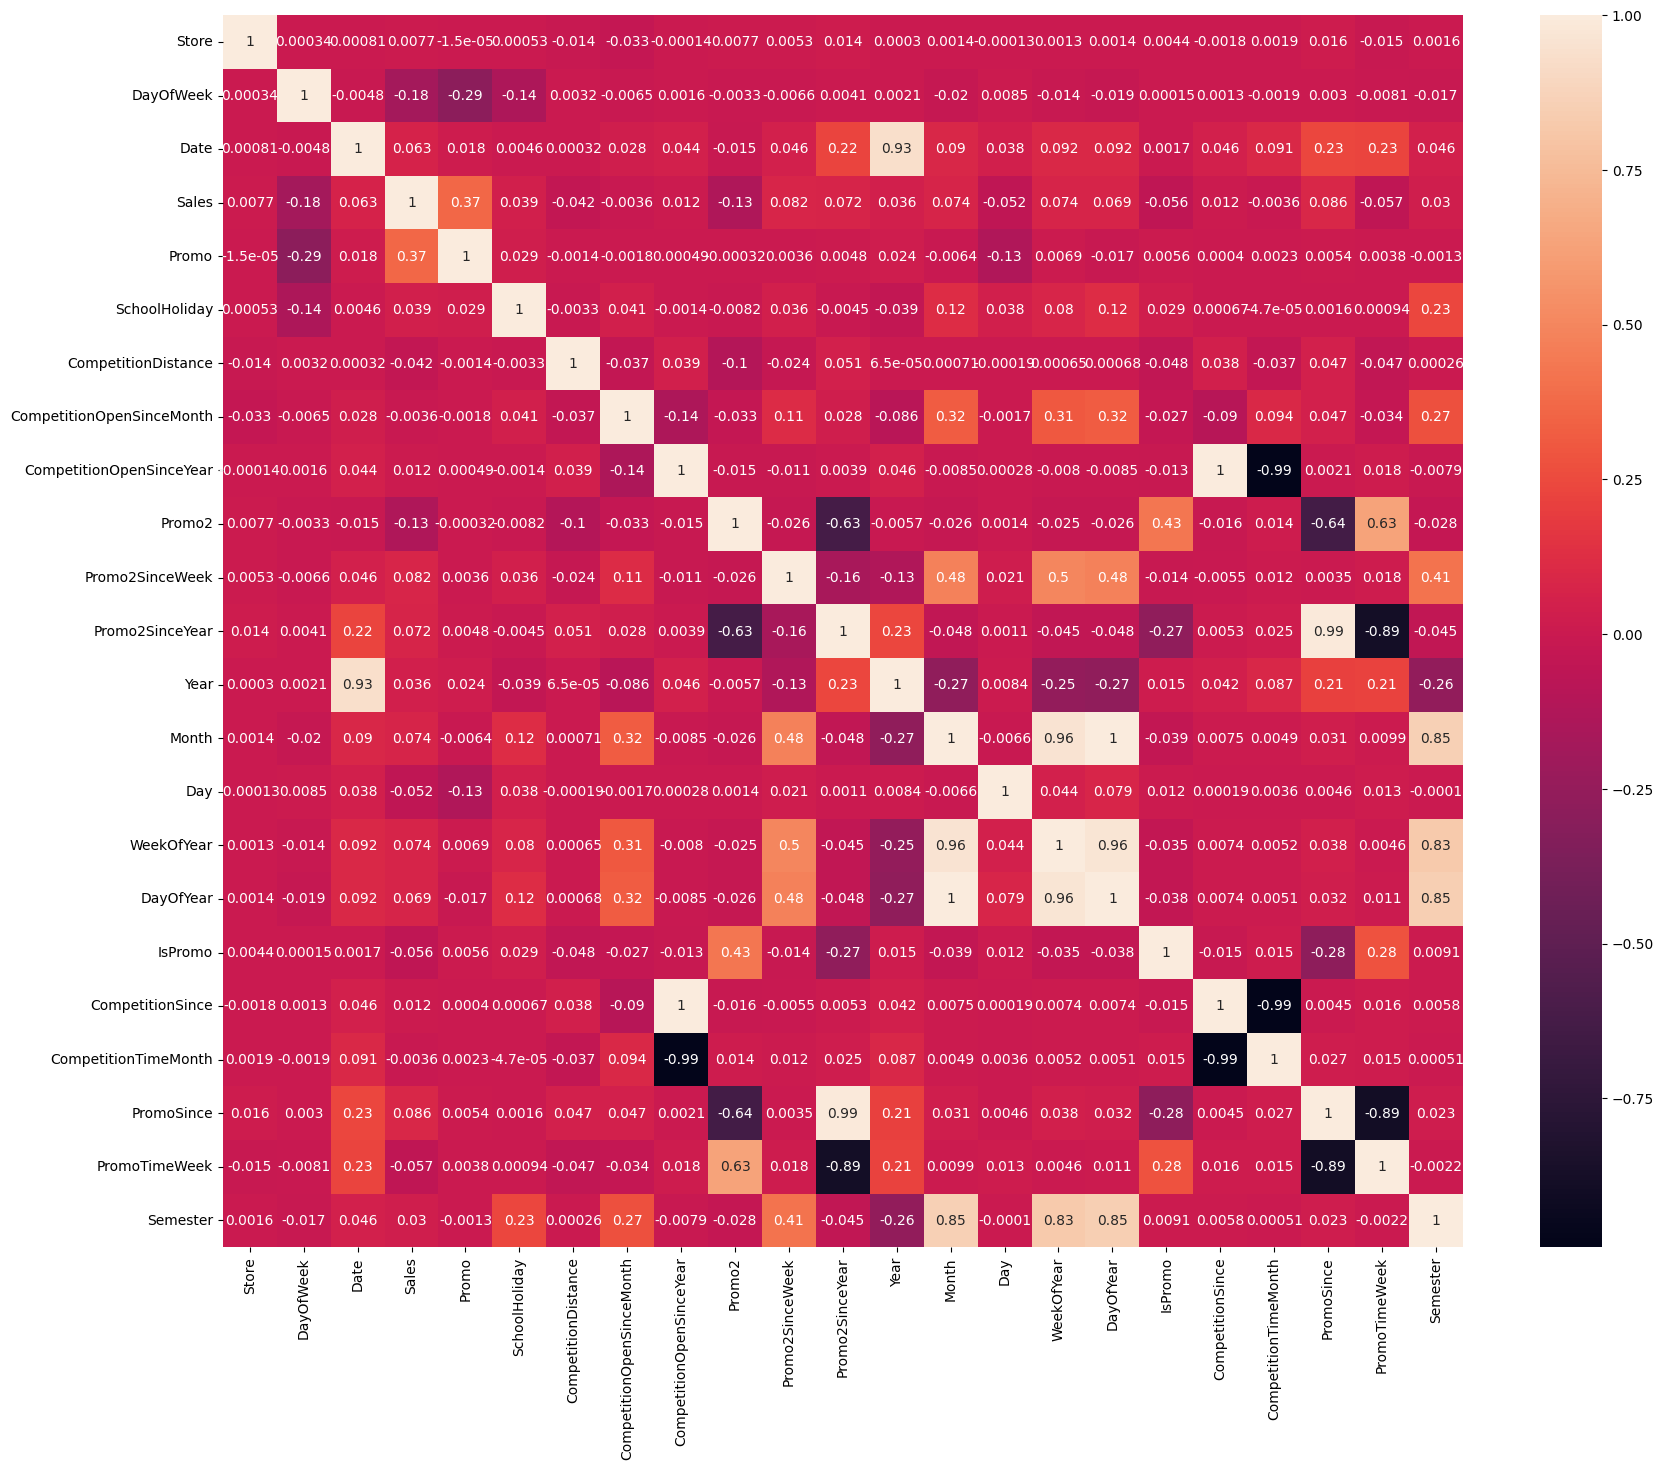

In [47]:
num_attributes = df1.select_dtypes(include=['int64', 'datetime64[ns]', 'bool'])
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [48]:
correlation

,Store,DayOfWeek,Date,Sales,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,DayOfYear,IsPromo,CompetitionSince,CompetitionTimeMonth,PromoSince,PromoTimeWeek,Semester
Store,1.000000,0.000343,0.000812,0.007723,-0.000015,0.000526,-0.014427,-0.033376,-0.000141,0.007728,0.005348,0.014475,0.000300,0.001371,-0.000127,0.001297,0.001359,0.004435,-0.001819,0.001924,0.015604,-0.015256,0.001586
DayOfWeek,0.000343,1.000000,-0.004828,-0.178753,-0.289268,-0.139319,0.003168,-0.006484,0.001594,-0.003252,-0.006624,0.004078,0.002099,-0.019710,0.008525,-0.014389,-0.018947,0.000149,0.001275,-0.001917,0.003030,-0.008131,-0.017058
Date,0.000812,-0.004828,1.000000,0.062734,0.018360,0.004595,0.000320,0.028039,0.044090,-0.015359,0.046152,0.222734,0.934569,0.090076,0.037834,0.092179,0.092268,0.001746,0.045719,0.091311,0.232412,0.226116,0.045670
Sales,0.007723,-0.178753,0.062734,1.000000,0.368199,0.038635,-0.041545,-0.003629,0.012437,-0.127556,0.082069,0.071753,0.036151,0.073589,-0.051865,0.074463,0.068699,-0.056076,0.012310,-0.003571,0.086429,-0.057257,0.029604
Promo,-0.000015,-0.289268,0.018360,0.368199,1.000000,0.028971,-0.001359,-0.001796,0.000491,-0.000316,0.003583,0.004779,0.023990,-0.006412,-0.126442,0.006947,-0.017426,0.005600,0.000400,0.002295,0.005412,0.003838,-0.001335
SchoolHoliday,0.000526,-0.139319,0.004595,0.038635,0.028971,1.000000,-0.003256,0.040614,-0.001356,-0.008244,0.036423,-0.004498,-0.038686,0.118467,0.038085,0.079584,0.120715,0.028790,0.000672,-0.000047,0.001568,0.000939,0.233028
CompetitionDistance,-0.014427,0.003168,0.000320,-0.041545,-0.001359,-0.003256,1.000000,-0.037215,0.039208,-0.104955,-0.024320,0.050614,0.000065,0.000711,-0.000189,0.000652,0.000684,-0.048347,0.037556,-0.037391,0.047369,-0.047303,0.000262
CompetitionOpenSinceMonth,-0.033376,-0.006484,0.028039,-0.003629,-0.001796,0.040614,-0.037215,1.000000,-0.139848,-0.033036,0.108603,0.028361,-0.086342,0.318716,-0.001684,0.306303,0.317573,-0.027129,-0.090181,0.093740,0.046960,-0.034146,0.271380
CompetitionOpenSinceYear,-0.000141,0.001594,0.044090,0.012437,0.000491,-0.001356,0.039208,-0.139848,1.000000,-0.014570,-0.010944,0.003851,0.045702,-0.008538,0.000280,-0.008029,-0.008517,-0.013483,0.998750,-0.989574,0.002121,0.018103,-0.007859
Promo2,0.007728,-0.003252,-0.015359,-0.127556,-0.000316,-0.008244,-0.104955,-0.033036,-0.014570,1.000000,-0.026169,-0.627189,-0.005696,-0.025807,0.001355,-0.024740,-0.025648,0.429300,-0.016338,0.014187,-0.640533,0.634461,-0.027979


Principais Apontamentos da Matriz de Correlação

> Correlação com a Variável Alvo (`Sales`)
>
> - Nenhuma variável apresenta correlação linear forte com `Sales`. 
> - As maiores correlações são moderadas.
>
> Multicolinearidade
>
> - Algumas variáveis têm correlação muito alta entre si, o que pode indicar redundância:

### Matriz de Cramer's V das Variáveis Categóricas

<Axes: >

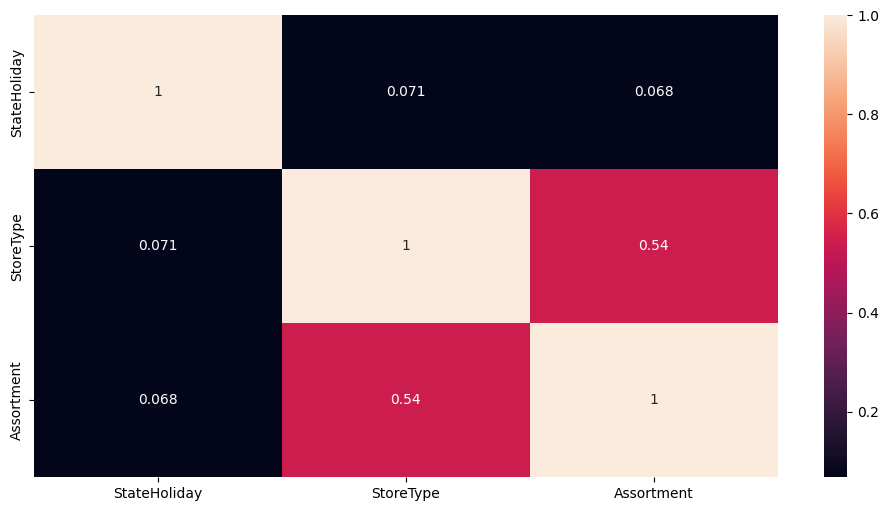

In [50]:
plt.figure(figsize=(12, 6))
# only categorical data
a = df_cat

# Calculate cramer V
a1 = cramer_v(a['StateHoliday'], a['StateHoliday'])
a2 = cramer_v(a['StateHoliday'], a['StoreType'])
a3 = cramer_v(a['StateHoliday'], a['Assortment'])

a4 = cramer_v(a['StoreType'], a['StateHoliday'])
a5 = cramer_v(a['StoreType'], a['StoreType'])
a6 = cramer_v(a['StoreType'], a['Assortment'])

a7 = cramer_v(a['Assortment'], a['StateHoliday'])
a8 = cramer_v(a['Assortment'], a['StoreType'])
a9 = cramer_v(a['Assortment'], a['Assortment'])

# Final dataset
d = pd.DataFrame({'StateHoliday': [a1, a2, a3], 
               'StoreType': [a4, a5, a6],
               'Assortment': [a7, a8, a9]})
d = d.set_index(d.columns)

sns.heatmap(d, annot=True)

> Não há correlações altas entre as variáveis categóricas, exceto uma associação moderada entre StoreType e Assortment.
>
> Após o treinamento, avalie a importância das features para possíveis ajustes.

## Resumo e Validação das Hipóteses

| Hipótese | Conclusão   | Relevância | Considerações                                                                                                 |
|----------|-------------|------------|--------------------------------------------------------------------------------------------------------------|
| 4        | Inválida    | Média      | Variedade maior de produtos (extended) não garante vendas maiores; basic e extended têm vendas similares.     |
| 5        | Inválida    | Alta       | Lojas com competidores mais próximos vendem mais; pode indicar localização em áreas de maior demanda.         |
| 6        | Inválida    | Média      | Lojas com competidores há mais tempo não vendem mais; tendência levemente negativa nas vendas.                |
| 11       | Inválida    | Alta       | Promoções prolongadas não aumentam vendas; efeito é mais forte no início e diminui com o tempo.               |
| 12       | Inválida    | Alta       | Mais dias de promoção não garantem vendas maiores; efeito de urgência pode ser perdido.                       |
| 14       | Válida      | Alta       | Lojas abertas no Natal vendem mais; maior mediana de vendas em todos os anos analisados.                      |
| 15       | Inválida    | Média      | Não há tendência clara de crescimento das vendas ao longo dos anos; 2015 apresenta queda.                     |
| 16       | Inválida    | Média      | Vendas só são significativamente maiores em dezembro, não em todo o segundo semestre.                         |
| 17       | Inválida    | Baixa      | Vendas não aumentam após o dia 10; média diária permanece estável ou levemente menor.                         |
| 18       | Parcialmente válida | Média | Total de vendas cai nos finais de semana; média por loja é baixa no sábado, mas alta no domingo (poucas lojas abertas). |
| 19       | Válida      | Alta       | Vendas são menores durante férias escolares; efeito consistente em todos os meses analisados.                 |

**Notas:**
> "Parcialmente válida" foi usada na hipótese 18 porque o total cai, mas a média por loja no domingo é alta devido a poucas lojas abertas.
>
> A relevância foi atribuída considerando o potencial impacto da variável na modelagem de vendas.